<a id='begining'></a>
[< go back to home](https://github.com/cglacet/Blog#my-publicationsnotes-on-various-subjects)

# One step closer to using Python properly

**Interactive version** here (it may take a few seconds to load): 
[![Binder](https://mybinder.org/badge_logo.svg)][interactive]

Using the interactive version is strongly advised as you'll be able to add your own test along the way without having to rewrite all the code. Don't worry, your changes do not affect how others will see the file, your changes are visible only to you. 


## Content

I'm always trying to improve my knowledge of python because it's my favorite language, that's the main reason why I'm writting this notes. Feel free to [contact me][mail] or to open an issue if you have any question or if you find something wrong/innacurate/outdated or even if you think I should look at a particular subject.

This article presents some python features that everyone should try using, but also covers more fundamental computer science questions on the way. I'll try to be as educational as possible but this is intended for people that already have basic knowledge in computer science. What I think are the prerequisite:

* types, typing (static typing and dynamic type checking)
* control structures if, for, while
* complexity analysis: being able to compute asymptotic complexities (for simple examples).
* computer architecture: in particular memory management,  
* ...


In most cases I'll present a problem, give a first implementation and progressively add python flavor to it. In some cases examples will come from code I saw on [Stackoverflow][stackoverflow] or [Exercism.io][exercism], sometimes the example will be a code of mine and in many cases the examples will be purely fictional. If by any chance you see a code you wrote here and you want it to be removed then you can [contact me][mail]. I'll always try to go as deep as I can in the explanations every piece of code will be an excuse to discuss implementation details and fundamental aspects.

Everytime you see the python logo somewhere, this means there is a link to the documentation of that particular function/method/class:

> **str.lower()** [<img src="images/py.png" style="display: inline; margin: 0 4px;" />][strlower]

Finally I'll answer the question **"Why is this all in one page?"** before you ask, it's because I find it so much easier to search for a topic in a single page using CTRL+F (or ⌘+F) instead of having to rely on a navigation system that would eventually fail.

Note that everything is more or less in arbitrary order (even though I'll try to maintain a complexity order, but this is mostly subjective), you can use the following indexes if you are looking for a specific subject.

## Topics Index

* **Built-in functions** [enumerate()](#enumerate_1), [map()](#map_1)
* **Built-in types** [range()](#range_1), [set()](#set_1), [tuple()](#type_tuple_1)
* **Itertools module** [takewhile()](#takewhile_1)
* **Asynchronous modules (coming next)** [async-await](#async-await), [asyncio](#asyncio)
* **Other modules** [timeit](#timeit_1)

## Paradigms/design patterns index

* [**Immutability**](#Immutability)


## Problems Index

* [**Statistics on population**](#Statistics-on-population)
* [**Finding vowels in a string**](#problem_vowels)


[exercism]: https://exercism.io
[stackoverflow]: https://stackoverflow.com/questions/tagged/python
[mail]: mailto:christian.glacet+python@gmail.com
[strlower]: https://docs.python.org/3/library/stdtypes.html#str.lower
[interactive]: https://mybinder.org/v2/gh/cglacet/Blog/master?filepath=python%2Fnotes.ipynb

### Some imports 

This is unrelated to python, these are just imports that I will use to make this Jupyter notebook able to display some markdown.

In [1]:
from IPython.display import display, Markdown

# Statistics on population

**Topics** Object Oriented Programming (OOP); Lists/Generators/Iterators ; ploting (coming next)

**Problem definition** Implement a population class that will act as a list of people (name/age). We will supose that we have different kind of users for our API, but we will focus on one particular user that is only interested in making statisticall analysis over our populations ages. 

**Constraints we will try to uphold are** performances, reusability and of course producing clean code. 


## Our first Python class — Person

Lets start by defining a `Person` type that we will not modify and use for the rest of the section.

In [2]:
from datetime import datetime

date_fmt = "%d/%m/%Y"

class Person:
    def __init__(self, name, birth_date):
        self.name = name
        self.birth = birth_date

    def age(self):
        return (datetime.today() - self.birth).days//365
    
    def __str__(self):
        return f"{self.name} is {self.age()} years old."
    
birth = datetime.strptime("31/07/1986", date_fmt)
chris = Person("Christian", birth)
print(chris)

Christian is 32 years old.


Several things are maybe a bit unusual compared to other languages:

1. The constructor will not be called explicitely.
2. We rarely interfere in the instanciation (therefore we rarely redefine the default constructor).
3. Attributes can be added to any existing instance, by anyone, at any time.

To understand that better here is (roughly) what's going on under the hood when you call `Person(name, birth_date)`:

In [3]:
# Simulate how a call to `Person(*args)` work:
def new_person(*args):
    # A) a new instance is created using the static method __new__
    instance = Person.__new__(Person, *args)
    # B) the instance is initialized (set attributes)
    instance.__init__(*args)
    # C) the initialized instance is returned to the caller
    return instance

# This is equivalent to calling `Person("Christian", birth)`:
chris = new_person("Christian", birth)
print(chris)

Christian is 32 years old.


What does that says: 

1. `Person.__new__` is the constructor of `Person`, in our case this constructor is unmodified and therefore inherited from the parent class `object` (note that in python 3 when you write `class Person` what it really means is `class Person(object)`, not having to explicitely state that we inherit from `object` is just [syntactic sugar][syntactic sugar]). Like in every inheritance case since `Person` doesn't redefine the constructor (neither overriding/overloading it) the inherited one will be used (ie. `object.__new__`).
2. Redefining `__new__` is somehting that you will rarely have to do as most of the time you don't need any control on how to instanciate new object of a given type. Exception could be when creating metaclasses, but we will talk about that later).

Now concerning point 3., here is a code that might surprise you depending on what language you come from:

[syntactic sugar]: https://www.wikiwand.com/en/Syntactic_sugar

In [4]:
# We will try to access an undefined attribute `last_name`
try:
    print(chris.last_name)
except:
    print(chris.name, "has no last name.")

tom = Person("Thomas", birth)

chris.last_name = "Glacet"
print(chris.last_name)
print(tom.last_name)

Christian has no last name.
Glacet


AttributeError: 'Person' object has no attribute 'last_name'

The `last_name` attribute is attached to the `chris` instance, other instances like `tom` are not aware of this and still raise an exception when trying to access this attribute: `AttributeError` is raised.

In python you can add attributes to existing instances, it's a choice that is probably related to [duck typing][duck typing wiki]. Since adding attributes to an instances doesn't supress any capability from it we can do it safely. This construction is what allow us to write the `__init__` method. Otherwise we wouldn't be able to add attributes to `self` inside this method like we did in `Person`:

```python
class Person:
    # This adds attributes to self:
    def __init__(self, name, birth_date):
        # at that point, the instance as "no attribute" (none of ours)
        self.name = name
        # now it has a `name` attribute
        self.birth = birth_date
        # now it has both `name` and `birth_date`
```

Since python call sucessively `__new__` and `__init__` every time `Person()` is called, all instances will have both attributes `name` and `birth_date`, that's the reason why we will assume everywhere else that these two exist. For example in the `__str__` method:


```python
    def __str__(self):
        return f"{self.name} is {self.age()} years old."
```

Note that this method is a special method that every class can define, it can be called in three different ways:


[duck typing wiki]: https://www.wikiwand.com/de/Duck-Typing

In [5]:
text_1 = chris.__str__()     # Explicitely (rarely useful)
text_2 = str(chris)          # Indirectly by using str()
text_3 = f"{chris}"          # Implicitely in formated strings
text_4 = "{}".format(chris)  # Implicitely in formated strings (2nd form)

print(chris)                 # print also calls str() on non-strings objects you pass to it
print(text_1)                # will print the same exact thing

text_1 == text_2 and text_2 == text_3 and text_3 == text_4

Christian is 32 years old.
Christian is 32 years old.


True

**Remark** we know we can add attributes to existing instances in python, but you can also:

* bind new method to existing classes ;
* and even bind new method to existing instances: [how do to that?][binding instance methods] ;

But this is not really something you should use unless more classic approach are not sufficient (inheritance, class decorators, ...).


[binding instance methods]: https://stackoverflow.com/a/2982/1720199

## Our second Python class — Population

We will start with the following class definition for `Population`:

In [6]:
from datetime import timedelta
import random

random.seed(0)

class Population:
    def __init__(self, people=None):
        self.people = people or []
    
    def append(self, person):
        self.people.append(person)
        return self
    
    def __iadd__(self, person):
        return self.append(person)
        
    def __str__(self):
        text = f"This population contains {len(self.people)} people:"
        for person in self.people:
            text += f"\n\t- {str(person)}"
        return text
    
def random_population(n=10):
    today = datetime.today()
    people = Population()
    for index in range(n):
        weeks = random.randint(50, 5000)
        birth = datetime.today() - timedelta(weeks=weeks)
        people.append(Person(f"Person {index}", birth))
    return people
        
        
my_people = random_population(5)
print(my_people)

This population contains 5 people:
	- Person 0 is 61 years old.
	- Person 1 is 67 years old.
	- Person 2 is 7 years old.
	- Person 3 is 41 years old.
	- Person 4 is 81 years old.


Now, imagine that you have some cases where you just want the ages of a population, for statistics. You will need that accessible in several places and you don't want to write a for loop every time you need it. One way to do that is to write a function that you'll call everytime you need that particular information about your population:

In [7]:
def population_ages(population):
    ages = []
    for person in population.people:
        ages.append(person.age())
    return ages

Which in this case would return:

In [8]:
population_ages(my_people)

[61, 67, 7, 41, 81]

This is the expected result but what if sometimes you only need to find the maximum age from your population. You could use this list and then iterate over it to find the `max` inside it. But this could be improved in two ways, since you woulc:

1. iterate over a list of size |my_people| twice. Once in `population_ages` and once to compute the max.
2. have two lists of size |my_people| in memory: `my_people` and the return value from `population_ages`.

Many languages come with a nice solution to this using **generators**: 

> Generator is a special routine that can be used to control the iteration behaviour of a loop. In fact, all generators are iterators. A generator is very similar to a function that returns an array, in that a generator has parameters, can be called, and generates a sequence of values. However, instead of building an array containing all the values and returning them all at once, a generator yields the values one at a time, which requires less memory and allows the caller to get started processing the first few values immediately.
>
> [Wikipedia — generator][generator]

Simplified version: "A generator gives you values one by one instead of all together encaspulated in a sequence". In python this can be achieved using the `yield` keyword inside a function. For example: 

[generator]: https://www.wikiwand.com/en/Generator_(computer_programming)

In [9]:
def my_first_generator():
    yield "Hello"
    yield "beautiful"
    yield "world!"

This generator can then be used extactly like iterators in any other language you know. In python there is a special module, named `itertools`, made to help you with iterators: **itertools module** 
<a id='itertools_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][itertools]

[itertools]: https://docs.python.org/3.7/library/itertools.html

In [10]:
it = my_first_generator()
print(next(it))

Hello


Or implicitely using iteration control struture, like a `for`:

In [11]:
for value in it:
    print(value)

beautiful
world!


Of course `yield` can be used as any other instruction, for example it can be used inside a `while`:

In [12]:
def generate_numbers():
    number = 0
    while True:
        yield number
        number += 1

This generates an infinite number of values, or rather an unbonded number of values. Here are two equivalent ways of iterating over this infinite generator by adding a control:

**itertools.takewhile(predicate, iterable)**
<a id='takewhile_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][itertools.takewhile]

[itertools.takewhile]: https://docs.python.org/3.7/library/itertools.html#itertools.takewhile

In [13]:
import itertools

limit = 4

for value in generate_numbers():
    if value > limit:
        break
    print(value, end=" ")
print()
    
# Or equivalently:
def leq(x):
    return x <= limit

for value in itertools.takewhile(leq, generate_numbers()):
    print(value, end=" ")
print()

0 1 2 3 4 
0 1 2 3 4 


In our case we can build a generator that will yield ages from a population:

In [14]:
def population_ages(population):
    for person in population.people:
        yield person.age()

Which returns:

In [15]:
population_ages(my_people)

<generator object population_ages at 0x110086a20>

As observed before, this generator allows us to do (almost) everything we would do with lists, for example, many built-in functions that take `list` as argument also take `generator`, in fact they take a more abstract type called [`iterable`][iterable ABC]. An example of such a function is `map`.

**map(function, iterable, ...)** 
<a id='map_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][map function]

As the documentations says, this returns an iterator that applies `function` to every item of `iterable`, yielding the results. It's very common to see lambda function passed as the first parameter to `map`, that usually the case when the function is extremely simple ("adding one" for example). In python, lambda functions are simply defined this way: `lambda <params>: <return value>`. Here is an example using our `population_ages` generator and some `map` functions:

[map function]: https://docs.python.org/3.7/library/functions.html#map
[iterable ABC]: https://docs.python.org/3.7/library/collections.abc.html#collections.abc.Iterable

In [28]:
# We can iterate over the generator (=> it's iterable):
print("Ages:", end=" ")
for age in population_ages(my_people):
    print(age, end=", ")
print()

# Therefore we can use map() on it:
print("Next year people will have ages:", end=" ")
for age_str in map(lambda x: x+1, population_ages(my_people)):
    print(age_str, end=", ")
print()

# We can chain functions on iterables:
next_ages = ", ".join(map(str, map(lambda x: x+1, population_ages(my_people))))
print("Next year people will have ages:", next_ages)

# And of course you can apply max on it:
print(f"Max age is {max(population_ages(my_people))}")

# On the other hand, you can't know the size of an iterable 
# because by definition, we don't have any idea what an iterable 
# contains before we consume it. It's not in memory!
print(len(population_ages(my_people)))

Ages: 61, 67, 7, 41, 81, 
Next year people will have ages: 62, 68, 8, 42, 82, 
Next year people will have ages: 62, 68, 8, 42, 82
Max age is 81


TypeError: object of type 'generator' has no len()

Note that if our client want to have a list instead of the generator (going back to the old version), he can simply do the following: 

In [29]:
list(population_ages(my_people)) # list() also takes any iterable as argument

[61, 67, 7, 41, 81]

If we look at the `map` function signature: `map(function, iterable, ...)` we can notice these `...` that's used in python's documentation to say that it take from 1 to any number of iterable. You'll often see another notation, like in `zip(*iterables)` this means from 0 to any number of iterable. This means that map can for example take 2 iterables as parameter:

In [30]:
population_next_ages = map(lambda x: x+1, population_ages(my_people))

def aging_text(from_age, to_age):
    return f"from age {from_age} to age {to_age}."

for text in map(aging_text, population_ages(my_people), population_next_ages):
    print(text)

from age 61 to age 62.
from age 67 to age 68.
from age 7 to age 8.
from age 41 to age 42.
from age 81 to age 82.


All iterables passed to `map` will be iterated through simultaneously and values will be used as inputs for the `function`. For example with an input `map(f, [1, 2], ['a', 'b'])`, the returned iterator will procude `f(1, 'a')` then `f(2, 'b')` and will finally stop. 

In the case where one iterable is longer than the other, `map(f, [1, 2], ['a', 'b', 'c'])`, the maping will stop as soon as the first iterable is consumed, here it would return the same as before: `f(1, 'a')` then `f(2, 'b')`.

Lets go back to the `Population` class, even if we keep adding functionalities to it over time, it can be described as a list of people to which we will attach other kinds of information (for example a population `name`). When we iterate over people from a population, it's a bit frustrating to have to write something like `for person in population.people:`. The population itself could defined as a `list` using inheritance, in python this look like this:

In [31]:
class Population(list):

    def ages(self):
        for person in self:
            yield person.age()
    
    # We need to redefine that, otherwise it would return a list: 
    def __add__(self, other):
        # As `list.__add__` do something that look like:
        #   return [*self, *other]
        # If we want a Population, we need to return that instead: 
        return Population([*self, *other])
        
    def __str__(self):
        text = f"This population contains {len(self)} people:"
        for person in self:
            text += f"\n\t- {str(person)}"
        return text
    

my_people = random_population(2)
some_other_people = random_population(3)

union_of_people = my_people + some_other_people
print(union_of_people)

This population contains 5 people:
	- Person 0 is 77 years old.
	- Person 1 is 64 years old.
	- Person 0 is 48 years old.
	- Person 1 is 75 years old.
	- Person 2 is 57 years old.


This is very practical, but in some occurences you'll need more control about what you want to offer. If you don't want **ALL** features that lists offer but you still want to have some, you'll need to implement something that not only a delegation (like we did the 1st time) neither a simple inheritance. The best solution you can have in this case would be to do both! Python offers a list of [abstract classes][collection.abc] you can inherit from to give you the guidlines on how to implement you class (ie., [template method][template method]). In our case you would need to inherit from `collections.abc.MutableSequence` and delegate the work to list when we want to:

[collection.abc]: https://docs.python.org/3.5/library/collections.abc.html
[template method]: https://www.wikiwand.com/en/Template_method_pattern

In [32]:
import collections

class Population(collections.abc.MutableSequence):
    pass

p = Population()

TypeError: Can't instantiate abstract class Population with abstract methods __delitem__, __getitem__, __len__, __setitem__, insert

That exception tells you what you need to implement, I wont implement those and I'll let this as an exercise.

---- 
<a id='problem_vowels'></a> <a id='problem_2'></a>
[< back to index](#Topics-Index)  — [next topic (async-await) >](#problem_3)

# Finding vowels and their positions in a string

**Topics** list/tuple/set ; Immutability ; Performance measures tools ; Complexity analysis

**Problem definition** The goal of this function is to show, for every vowel in an input string, both the wovel and the index at which it was found in the string.

In [33]:
user_input = "Some user input."
vowels = "aeiouAEIOU"

In [34]:
position = 0
for char in user_input:
    if char in vowels:
        print(char, position, end=" - ")
    position += 1

o 1 - e 3 - u 5 - e 7 - i 10 - u 13 - 

**enumerate(iterable, start=0)** 
<a id='enumerate_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][enumerate]

This code can be improved to be a bit more pythonic, using `enumerate` can save you from keeping track of the position by hand:


[enumerate]: https://docs.python.org/3.5/library/functions.html#enumerate

In [35]:
for position, char in enumerate(user_input):
    if char in vowels :
        print(char, position, end=" - ")

o 1 - e 3 - u 5 - e 7 - i 10 - u 13 - 

**class set([iterable])** <a id='set_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][set]

Another improvement can be made, this time we can improve performances. Time cost of checking `char in vowels` is proportional to the size of the string `vowels`. On the other hand you can change the type of `vowels` from `string` to `set`, checking if an item is part of a set is done in constant time:

[set]: https://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset

In [36]:
vowels = set(vowels)
for pos, char in enumerate(user_input):
    if char in vowels:
        print(char, pos, end=" - ")

o 1 - e 3 - u 5 - e 7 - i 10 - u 13 - 

Sets are a very common type and you are probably already very used to it. One remark though is that `set()` can not take any iterable as parameter.

In [37]:
items = set([[1, 2, 3], [4, 5]])

TypeError: unhashable type: 'list'

This error is raised because both lists `[1, 2, 3]` and `[4, 5]` are unhashable. In fact, any [`list`][pydoclist] is unhashable. This is how hashable is defined in Python's documentation:

> An object is hashable if it has a hash value which never changes during its lifetime, [[...]][term-hashable]

Basically, a hashable object must (at least) be immutable (I dedicated a section to explaining what [**immutable?**](#Immutability) means). Python have some hashable types ([`text sequence`][text sequence], [`numerics`][numerics], ...) and some unhashable types like `list`. On the other hand, in this specific case we could change our lists to tuples to have a set of sequences. Note that if your favorite set or map objects do not throw this error, [this could be a problem][identity mutability]. 

[text sequence]: https://docs.python.org/3/library/stdtypes.html#text-sequence-type-str
[numerics]: https://docs.python.org/3/library/stdtypes.html#numeric-types-int-float-complex
[pydoclist]: https://docs.python.org/3/library/stdtypes.html#list
[term-hashable]: https://docs.python.org/3/glossary.html#term-hashable
[identity mutability]: https://www.yegor256.com/2014/06/09/objects-should-be-immutable.html#avoiding-identity-mutability

**class tuple([iterable])** 
<a id='type_tuple_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][tuple]

Tuples can roughly be seen as immutable lists. In python, lists tend to be prefered when inner items all share the same type, whereas tuples can be, and usually are, used when items are not of homogeneous type. The only case where tuples are used even on homogeneous items is when a hashable type is needed. Which is precisely the case here: 


[tuple]: https://docs.python.org/3/library/stdtypes.html#tuple

In [38]:
item_a = (1, 2, 3)
item_b = (4, 5)
items = set([item_a, item_b])
(1, 2, 3) in items

True

Note that since sets items are immutable, if `(1, 2, 3) in items` evaluates to `True` then it will *ALWAYS* be evaluated to `True` (unless it is removed from the `items` set of course).

As always immutability comes with benefits, mainly: *it is safe to use as you know nothing will ever modify your objects*. But it also has its down sides, mainly: *people are usually not used to it* and *in some cases it's less performant*. Just to make sure we agree on what immutability is, I'll talk a little bit about it in the next section (or you can just [skip it](#Immutable-sequence-implementation) if you already know what immutability implies).

# Immutability

`$ define immutable`

> In object-oriented and functional programming, an immutable object (unchangeable object) is an object whose state cannot be modified after it is created. This is in contrast to a mutable object (changeable object), which can be modified after it is created.

Eventhough this definition is extremely simple and clear, understanding all the implications of immutability takes some time and practice. You must already be used to immutable objects since most modern languages use immutable objects for simple objects (string, numbers, booleans, ...). Here is an interesting discussion you can read if you want to understand ["Why are Python strings immutable?"][why string immutable].

It's very easy to check if a type is mutable or immutable and the technique would be the same for every language. For example, we can check that tuples are immutable in python:


[why string immutable]: https://stackoverflow.com/questions/8680080/why-are-python-strings-immutable-best-practices-for-using-them

In [39]:
a = (1, 2, 3)
b = a
b += (4, 5, 6)
a

(1, 2, 3)

Whereas lists can be mutated:

In [40]:
a = [1, 2, 3]
b = a
b += [4, 5, 6]
a

[1, 2, 3, 4, 5, 6]

We can go a bit further to obvserve a concrete implication of this fact. Lets build an library that offers to print the `vowels` from an `user_input`. We know that people will tend to forgot uppercase version of their vowels so we also decide that we will add these automatically for them.

We will present our code first, then we will show how the user can experience bugs.

### The library

We couldn't decide whether we wanted `vowels` to be a list or a tuple, so we decided to delegate that decision to our client and implement both versions:

In [41]:
def print_using_wovel_list(user_input, vowels):
    print("List:", end=" \t ")
    vowels += list(c.upper() for c in vowels)
    for c in user_input:
        if c in vowels:
            print(c, end=" ")
    print()
            
def print_using_wovel_tuple(user_input, vowels):
    print("Tuple:", end=" \t ")
    vowels += tuple(c.upper() for c in vowels)
    for c in user_input:
        if c in vowels:
            print(c, end=" ")
    print()

### The client

Lets now see how our client will use these two functions. The client simply wants to:

1. define some vowels
2. print the vowels from an `user_input`
3. remove the first vowels defined in 1.
4. print the vowels from an `user_input` again

The client want to make this with both lists and tuples. For a `user_input` set to `"I AM an input, are YOU?"`, his expected result is to have (for 2. and 4.) the following outputs (for both list and tuple versions):

```python
I A a i u a e O U     # All vowels from `user_input`
I i u e O U           # Same without a's or A's
```


In [42]:
user_input = "I AM an input, are YOU?"
lower_vowel_l = list("aeiou")
lower_vowel_t = tuple("aeiou")

print("List: \t vowels are", lower_vowel_l)
print("Tuple: \t vowels are", lower_vowel_t)

print("-----")

print_using_wovel_list(user_input, lower_vowel_l)
print_using_wovel_tuple(user_input, lower_vowel_t)

print("-----")
print("List: \t removing vowel", lower_vowel_l[0])
print("Tuple: \t removing vowel", lower_vowel_t[0])
lower_vowel_l.pop(0)
lower_vowel_t = lower_vowel_t[1:]

print("-----")
print_using_wovel_list(user_input, lower_vowel_l)
print_using_wovel_tuple(user_input, lower_vowel_t)

List: 	 vowels are ['a', 'e', 'i', 'o', 'u']
Tuple: 	 vowels are ('a', 'e', 'i', 'o', 'u')
-----
List: 	 I A a i u a e O U 
Tuple: 	 I A a i u a e O U 
-----
List: 	 removing vowel a
Tuple: 	 removing vowel a
-----
List: 	 I A i u e O U 
Tuple: 	 I i u e O U 


We can see here that the second output is different for lists and tuples, the tuple result is the expected one whereas the list result contains an unwanted `A`. The client can't have any idea where that bug comes from in his code, for good a reason since **the bug doesn't come from his code, but from ours**.

The error we made is to modify the clients input `vowels` inside `print_using_wovel_list`. When working with mutable objects, **there are things we can do** (raising no exceptions) **but that we shouldn't be doing**. For example, like in this case, when handed an object we should never modify it in place (mutate it), never. You could ask whats the problem then, once we know we shouldn't do it we should just be careful with that. But are you sure we will **always** remember that? Maybe you will, but eventually someone wont. And when it happens, not only that it will create bugs but it will create very hard to find bugs. We will have an object that will change form without us noticing it. Debugging this will basically mean observing the faulty object until we find the place where its mutated.

### Should we use immutable objects?

**Having immutable objects is the guarantee for us that this will NEVER happen**, and never is really important because that what allow us to have no fear and focus on the important stuff instead of wondering how things could eventually turn bad. Immutability is an insurance to make your code safer, to give you control over your instances' values (in particular when instances are accessed concurently, we will see an example of that in the [async-await](#async-await) section). At that point you're probably asking yourself why isn't everyone using immutable objects everywhere? The main reason is performances issues, depending on what you want to do with your objects, making them immutable can have a big cost. Like always, when picking a data structure you need to chose it carefully depending on what you plan to do with it.


Here is a python example in which using tuples instead of lists is very costly. In this example we will use a very useful function (generator) called `range` together with `timeit`.

**class range(stop) — class range(start, stop[, step])** 
<a id='range_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][range]

**timeit.timeit(stmt='pass', setup='pass', timer=<default timer>, number=1000000, globals=None)**
<a id='timeit_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][timeit]
    

*The `timeit` function will not be used directly here as Jupyter offers a tool that interact better with our notebook here, but the principle is the same.*

[range]: https://docs.python.org/3.5/library/stdtypes.html#range
[timeit]: https://docs.python.org/3.5/library/timeit.html

In [43]:
import timeit

n = 10000

def list_test_case():
    acc = []
    for x in range(n):
        acc += [x]
    return acc

def tuple_test_case():
    acc = ()
    for x in range(n):
        acc = acc + (x,)
    return acc

print("List: ")
%timeit -r 5 list_test_case()

print("\nTuple: ")
%timeit -r 5 tuple_test_case()

List: 
1.04 ms ± 10.7 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)

Tuple: 
163 ms ± 5.32 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


On the flip side, a use case in which using tuples (or "any" immutable object) has almost no cost is when dealing with a "few" number of arbitrary sized updates. This is for example well suited to maitaining a global state that reacts on calls from an API or a evel slowers calls from a humain interacting with you application. That's the reason why libraries like [React Native.js][react-native] are using immutable [states][react-native state]. Here is what a python utility for updating states could look like in two cases, where the application state is either a `list` or a `tuple`: 

[react-native]: https://facebook.github.io/react-native/
[react-native state]: https://facebook.github.io/react-native/docs/state.html

In [44]:
n = 1000

def list_state_update(prev_state, update_state_with):
    prev_state = list(prev_state)
    update_state_with = list(update_state_with)
    prev_state += update_state_with
    return prev_state

def tuple_state_update(prev_state, update_state_with):
    prev_state = tuple(prev_state)
    update_state_with = tuple(update_state_with)
    return prev_state + update_state_with

prev_state = range(n)
update_state_with = range(n, 2*n)

print("List: updating state")
%timeit -r 5 list_state_update(prev_state, update_state_with)

print("\nTuple: updating state")
%timeit -r 5 tuple_state_update(prev_state, update_state_with)

List: updating state
45.8 µs ± 2.35 µs per loop (mean ± std. dev. of 5 runs, 10000 loops each)

Tuple: updating state
50.2 µs ± 767 ns per loop (mean ± std. dev. of 5 runs, 10000 loops each)


### Concluding remarks

Notice how these two pieces of code almost take the same time to execute. When that's the case there is no real argument against using immutable objects, the only disavantage being that "_people are sometimes not used to immutability_". But the good thing is, they can't screw up even if they don't know what they are doing.

A final remark on this could be a quote from Oracle:

> Programmers are often reluctant to employ immutable objects, because they worry about the cost of creating a new object as opposed to updating an object in place. The impact of object creation is often overestimated, and can be offset by some of the efficiencies associated with immutable objects. These include decreased overhead due to garbage collection, and the elimination of code needed to protect mutable objects from corruption.


We are also here to talk about python, not only abstract concepts, so, how is immutability achievable in python? The language itself doesn't garantee immutability of all objects as we now know, so can we really do it? We will try to answer these question by implementing a class that produces (sort of) immutable sequences and we will analyse the performances of different solutions.

# Immutable sequence implementation

As an exercise we will implement a `Tuple` class built on top of the existing `list` class. We will only do this for the example, therfore we won't implement all methods from `list` but just some to demonstrate the basic idea.

We will use python's "[**\_\_magic_methods\_\_**][magic methods]" which can roughly be described this way:

> The so-called magic methods have nothing to do with wizardry. You have already seen them in previous chapters of our tutorial. They are special methods with fixed names. They are the methods with this clumsy syntax, i.e. the double underscores at the beginning and the end. They are also hard to talk about. How do you pronounce or say a method name like `__init__`? *"Underscore underscore init underscore underscore"* sounds horrible and is nearly a tongue twister. *"Double underscore init double underscore"* is a lot better, but the ideal way is *"dunder init dunder"* That's why magic methods methods are sometimes called **dunder methods**! 
>
> So what's magic about the `__init__` method? The answer is, you don't have to invoke it directly. The invocation is realized behind the scenes. When you create an instance `x` of a class `A` with the statement `x = A()`, Python will do the necessary calls to `__new__` and `__init__`. 
> 
>[Python course][python course]

In our case we want to redefine how (list) concatenation works, the usual way of concatenating two lists `A` and `B` is to call `A + B` which return a new list, or by calling `A += B` (which is equivalent to calling `A.extend(B)`):

[python course]: https://docs.python.org/3/reference/datamodel.html#emulating-container-types
[magic methods]: https://www.python-course.eu/python3_magic_methods.php

In [45]:
from copy import copy

class Tuple(list):
    def __init__(self, iterable=None):
        if iterable is None:
            iterable = []
        super().__init__(iterable)
    def __add__(self, other):
        return Tuple([*self, *other])
    
    __radd__ = __add__
    __iadd__ = __add__
        
a = Tuple([1, 2, 3])
copy_of_a = copy(a)   # another way to help us decide if `a` is immutable
b = a
b += Tuple([4, 5, 6])

a == copy_of_a        # should be True if concatenation didn't mutate `a`

True

This seems to work as both `a` and its copy have the same value. This is not the most efficient implementation of an immutable sequence, python `tuple` are definitively not implemented in such a naive way, but that's the decent approximation we need here.

**dir([object])** <a id='dir_1'></a>
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][dir]

Lets now try to hack this first implementation, to this end lets first see what method we can access (we inherited from `list` therefore our `Tuple` has methods we haven't wrote ourselves):

[dir]: https://docs.python.org/3.5/library/functions.html#dir

In [46]:
print(dir(Tuple))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


We can see that there are a lot of *dunder methods* to define the comportement of lists in regards of built-in operations, for example `__getitem__` is the method called on `some_list[some_index]`. There also is its counterpart `__setitem__` which is called on `some_list[some_index] = some_value`. Do you think this is a problem for us, remember, we don't want to allow any mutation of our `Tuple` instance, lets try it:


In [47]:
a = Tuple([1, 2, 3])
a[0] = 0
a

[0, 2, 3]

As you might have guessed before **it is a problem**, how can we solve it? Line 2. `a[0] = 0` calls `a.__setitem__(0, 0)`, what we need to do is to intercept that and do something so `a` is not mutated. We can inspire ourself from how `tuple` react to that attack:  

In [48]:
b = tuple([1, 2, 3])
b[0] = 0

TypeError: 'tuple' object does not support item assignment

That looks like the best solution. Since setting an item in place is not allow, we should throw an error to make sure the client using `Tuple` knows that what he is trying to do will have no effect. This solution is better than just silently ignoring this affectation because it may otherwise lead to bugs in the client code. Lets add that to our `Tuple` by redefining `Tuple`'s [`__setitem__`][__setitem__] method:

[__setitem__]: https://docs.python.org/3/reference/datamodel.html#object.__setitem__

In [49]:
class BetterTuple(Tuple):
    def __setitem__(self, key, value):
        raise TypeError(f"'{type(self).__name__}' object does not support item assignment.")
        
a = BetterTuple([1, 2, 3])
a[0] = 0

TypeError: 'BetterTuple' object does not support item assignment.

One small detail of implementation, we may have simply raised the following error: 

```python
raise TypeError("'BetterTuple' object does not support item assignment.")
```

But what if we later decide to rename `BetterTuple` to simply `Tuple`, say when all clients stoped using the deprecated (broken) `Tuple`, then we would have to change this piece of code in addition to simply renaming the class. This may not be a problem if you class is small, but if you class is big and you do print hardcoded messages in different places, then you'll have to search an replace them, not the funniest thing to do. That's the reason why we instead get the type of `self` using `type(self)` (note that this is [almost equivalent to `self.__class__`][__class__ vs. type()]), in our case this returns a type object `t` which is a class: `<class '__main__.BetterTuple'>`, from which we can retrieve the class' name [`t.__name__`][__name__].

Is our `BetterTuple` class still broken (mutable)? I'll leave it as an exercice, have a look back at what `dir` says about our new class. Try to find methods that can be used to mutate instances of `BetterTuple`. We redefined dunder methods but we didn't redefined non-dunder methods from `list`, that's something you can look for. 

[__class__ vs. type()]: https://stackoverflow.com/a/511059/1720199
[__name__]: https://docs.python.org/3/reference/import.html#__name__

### Remarks on  concatenation complexity

The concatenation implementation of `Tuple` (and therefore of `BetterTuple`) has a complexity of $O(n+m)$. There are several ways of achieving the same thing with a better complexity, for example using [Ropes][wikipedia ropes] in which insertion\concatenation are in $O(\log n)$.

Lets see how performant this is compared to the real `tuple`. We have two tuples that (in theory) should have the same interfaces (they both share the exact same set of methods). We can use this to make our code a bit simpler than what we did when we compared lists with tuples. In Python both functions are classes are [first-class citizen][wikipedia first-class].


[wikipedia ropes]: https://www.wikiwand.com/en/Rope_(data_structure)
[wikipedia first-class]: https://www.wikiwand.com/en/First-class_citizen

# Metaclasses — first class citizens

Being first-class citizen means that classes can be used as object, but how does it work under the hood? 

In python classes are themselves instances of another class. That look to make no sense, because it doesn't really, you can't make sense of that if you stay inside python. If all classes are instances of another class, then how was the first class instanciated? And what is its type? It's a bit like Chicken-and-egg. But there is a solution to this particular dilema. In python, the base type of a metaclass is called `type`. This class (yes!) is built outside the logic of the python language which allow such a twisted outcome where `type` is of its own type (since its also a class). Basically you just need to have faith in the fact that `type` is well defined and that all classes are of type `type`. You can find an interesting Stackoverflow post about this: ["How does Cpython implement its type Objects, i.e. type's type is always type?
"][type is of type type]. Just for fun:


[type is of type type]: https://stackoverflow.com/questions/18692033/how-does-cpython-implement-its-type-objects-i-e-types-type-is-always-type

In [50]:
print(type(type))
print(type(type(type(type))))
print(type(type(type(type(type(type(type)))))))

<class 'type'>
<class 'type'>
<class 'type'>


Now back to the good part! Now we know that everything in python is an object (an instance of some class), even classes which are instances of `type`. That means we can store classes in variables, pass them as function parameters, return them, etc.. In our particular example, we want to evaluate the performances of two classes that both implement the same methods. Therefore we can pass them as parameter to a test function, which then will instanciate the class (either `tuple` or `Tuple`) and will finally run the test, not knowing which class it has instanciated but:

> If it walks like a duck and it quacks like a duck, then it must be a duck — [wikipedia][duck typing]

Lets see how the code look like: 


[duck typing]: https://www.wikiwand.com/en/Duck_typing

In [51]:
import timeit

# Takes a class as parameter
def many_small_increments(ClassName):
    # Instanciate the class (we don't need to know its type)
    acc = ClassName()
    for x in range(n):
        # Try to make it "quack like a duck":
        acc = acc + (x,)
    # If it all worked out "then it must be a duck"
    return acc

# Exact same principle:
def one_large_increment(ClassName):
    prev_state = ClassName(range(n))
    update_state_with = ClassName(range(n, 2*n))
    return prev_state + update_state_with


print("Python tuple: ")
%timeit -r 5 many_small_increments(tuple)
print("\nOur Tuple: ")
%timeit -r 5 many_small_increments(Tuple)


print("\nPython tuple: ")
%timeit -r 5 one_large_increment(tuple)
print("\nOur Tuple: ")
%timeit -r 5 one_large_increment(Tuple)

Python tuple: 
1.16 ms ± 14.3 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)

Our Tuple: 
4.82 ms ± 38.5 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)

Python tuple: 
51 µs ± 780 ns per loop (mean ± std. dev. of 5 runs, 10000 loops each)

Our Tuple: 
60.5 µs ± 511 ns per loop (mean ± std. dev. of 5 runs, 10000 loops each)


If you are interested in more complex immutable data structures you can also have a look at [zippers][1], this article explains what zippers are, why/when they are usefull and also how to build one in python.

[2]: https://github.com/cglacet/exercism-python/blob/master/zipper/README.md#howwhy-to-implement-zippers

<a id='problem_flatten_nested_lists'></a> <a id='problem_3'></a>
[< back to index](#Topics-Index)  — [next topic (async-await) >](#problem_4)

# Flattening nested list with indices
#### EN cours …

Suppose we have an input list that is nesteed and has an unbounded depth. We want to have a function `f` that will flatten that list and also return a list of indexes in the main list.

```python
>>> nested = ['', '', '', ['', [['a', 'b'], ['c']]], [[['a', 'b'], ['c']]], [[['d']]]]
>>> item_indexes, flat_list = flat_indexes(nested)
>>> print(item_indexes)
[0, 1, 2, 3, 3, 3, 3, 4, 4, 4, 5]
>>> print(flat_list)
['', '', '', '', 'a', 'b', 'c', 'a', 'b', 'c', 'd']
```

Here is a first naïve implementation of `flat_indexes(nested)`:

In [57]:
def flat_indexes(nested, current_index=None):
    """Return a flat version of `nested` together with a list of indexes at which 
    each item was found in the original list (independently of how deep it was found)."""
    flattened_list = []
    indexes = []
    if not isinstance(nested, list):
        flattened_list.append(nested)
        indexes.append(current_index)
    else:
        for i, sub_list in enumerate(nested):
            if current_index is None:
                sub_indexes, sub_list = flat_indexes(sub_list, i)
            else:
                sub_indexes, sub_list = flat_indexes(sub_list, current_index)
            flattened_list.extend(sub_list)
            indexes.extend(sub_indexes)
    return indexes, flattened_list

In [58]:
nested = ['', '', '', ['', [['a', 'b'], ['c']]], [[['a', 'b'], ['c']]], [[['d']]]]
item_indexes, flat_list = flat_indexes(nested)
print(item_indexes)
print(flat_list)

[0, 1, 2, 3, 3, 3, 3, 4, 4, 4, 5]
['', '', '', '', 'a', 'b', 'c', 'a', 'b', 'c', 'd']


That looks good, we don't look to have any performance issue here as we only perform two insertions per item in the input list. On this other hand, there is a **hidden bug** in this code. The main problem here is the docstring, it says that it will flaten any nested list passed a parameter. Which we will see is not true. Let's build a test case that will demonstrate why:

In [59]:
def build_nested_list(max_depth):
    sub_list = [max_depth]
    for distance in range(max_depth):
        sub_list = [max_depth-distance-1, sub_list]
    return sub_list

print("For example: ", build_nested_list(4))

For example:  [0, [1, [2, [3, [4]]]]]


Lets now try to see how our implementation reacts to deeply nested lists:

In [60]:
try:
    item_indexes, flat_list = flat_indexes(build_nested_list(3000))
except RecursionError as e:
    print("Exception: ", e)

Exception:  maximum recursion depth exceeded while calling a Python object




**Important remark** unless you are certain your lists will not be nested too deeply, you shouldn't use any recursion-based solution. Otherwise as soon as you'll have a nested list with depth greater than 1000, your code will crash. I explain this [here][1]. Note that a simple call to `str(list)` will crash on a test case with `depth > 1000`. The typical exception you'll have when using recursion-based solutions is (this in short is due to how python call stack works): 

```python
RecursionError: maximum recursion depth exceeded ... 
```

## Implementation details

I'll go step by step, first we will flatten a list, then we will output both the flattened list and the depth of all items, and finally we will output both the list and the corresponding item indexes in the "main list". 


### Flattening list

That being said, this is actually quite interesting as the iterative solution is perfectly designed for that, you can take a simple (non-recursive) list flattening algorithm:

```python
def flatten(iterable):
    return list(items_from(iterable))

def items_from(iterable):
    cursor_stack = [iter(iterable)]
    while cursor_stack:
        sub_iterable = cursor_stack[-1]
        try:
            item = next(sub_iterable)
        except StopIteration:       # post-order
            cursor_stack.pop()
            continue
        if isinstance(item, list):  # pre-order
            cursor_stack.append(iter(item))
        else:
            yield item              # in-order
```

### Computing depth

We can have access to the depth by looking at the stack size, `depth = len(cursor_stack) - 1`

```python
        else:
            yield item, len(cursor_stack) - 1      # in-order
```

Once you've done that, your function will return a generator of pairs (item, depth), we will thus need to split this in two different sequences to have the desired output:

```python
>>> a = [1,  2,  3, [4 , [[5, 6], [7]]], [[[8, 9], [10]]], [[[11]]]]
>>> pair_list = flatten(a)
>>> print(pair_list)
[(1, 0), (2, 0), (3, 0), (4, 1), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3)]
>>> flat_list, depths = zip(*pair_list)
>>> print(flat_list)
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
>>> print(depths)
(0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3)
```

We will now do something similar to have item indexes instead of the depth. 

### Solution — computing item indexes 

To instead compute item indexes (in the main list), you'll need to count the number of items you've seen so far, which can be done by adding 1 to an `item_index` every time we iterate over an item that is at depth 0 (when the stack size is equal to 1):  

```python
def flatten(iterable):
    return list(items_from(iterable))

def items_from(iterable):
    cursor_stack = [iter(iterable)]
    item_index = -1
    while cursor_stack:
        sub_iterable = cursor_stack[-1]
        try:
            item = next(sub_iterable)
        except StopIteration:             # post-order
            cursor_stack.pop()
            continue
        if len(cursor_stack) == 1:        # If current item is in "main" list
            item_index += 1               
        if isinstance(item, list):        # pre-order
            cursor_stack.append(iter(item))
        else:
            yield item, item_index        # in-order
```

This would print the following:

```python
>>> a = [1,  2,  3, [4 , [[5, 6], [7]]], [[[8, 9], [10]]], [[[11]]]]
>>> flat_list, item_indexes = map(list, zip(*flatten(a)))
>>> print(flat_list)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
>>> print(item_indexes)
[0, 1, 2, 3, 3, 3, 3, 4, 4, 4, 5]
```

### Handling iterable inputs

Being able to take a broader palette of nested iterables as input could be desirable (especially if you build this for others to use). For example, the current implementation doesn't work as expected if we have nested iterables as input, for example: 

```python
>>> a = iter([1, '2',  3, iter([4, [[5, 6], [7]]])])
>>> flat_list, item_indexes = map(list, zip(*flatten(a)))
>>> print(flat_list)
[1, '2', 3, <list_iterator object at 0x100f6a390>]
>>> print(item_indexes)
[0, 1, 2, 3]
```

If we want this to work we need to be a bit careful because strings are iterable but we want them to be considered as atomic items (not a as lists of characters). Instead of 

```python
        if isinstance(item, list):        # pre-order
            cursor_stack.append(iter(item))
        else:
            yield item, item_index        # in-order
````

We can replace this by: 

```python
       if not isinstance(item, str):
            try:
                cursor_stack.append(iter(item))
                continue
            except TypeError:
                pass
        yield item, item_index
```

The idea here is that if `iter` works, that means that `item` is an iterable, if it fails `TypeError` then we can assume that we are working on an atomic item, we can therefore yield it.

With this implementation, we have: 

```python
>>> a = iter([1, 2,  3, iter([4, [[5, 6], [7]]])])
>>> flat_list, item_indexes = map(list, zip(*flatten(a)))
>>> print(flat_list)
[1, '2', 3, 4, 5, 6, 7]
>>> print(item_indexes)
[0, 1, 2, 3, 3, 3, 3]
```

### Building test cases

If you need to generate tests cases with large depths, you can use this piece of code: 

```python
def build_deep_list(depth):
    """Returns a list of the form $l_{depth} = [depth-1, l_{depth-1}]$
    with $depth > 1$ and $l_0 = [0]$.
    """
    sub_list = [0]
    for d in range(1, depth):
        sub_list = [d, sub_list]
    return sub_list
```

You can use this to make sure my implementation doesn't crash when the depth is large: 

```python
a = build_deep_list(1200)
flat_list, item_indexes = map(list, zip(*flatten(a)))
```

We can also check that we can't print such a list by using the `str` function: 

```python
>>> a = build_deep_list(1200)
>>> str(a)
RecursionError: maximum recursion depth exceeded while getting the repr of an object
```

Function `repr` is called by `str(list)` on every element from the input `list`. 

### Concluding remarks

In the end I agree that recursive implementations are way easier to read (as the call stack does half the hard work for us), but when implementing low level function like that I think it is a good investment to have a code that works in all cases (or at least all the cases you can think of). Especially when the solution is not that hard. That's also a way not to forget how to write non-recursive code working on tree-like structures (which may not happen a lot unless you are implementing data structures yourself, but that's a good exercise). 

Note that everything I say against recursion is only true because python doesn't optimize call stack usage when facing recursion: [_Tail Recursion Elimination in Python_](http://neopythonic.blogspot.com/2009/04/tail-recursion-elimination.html). Whereas many compiled languages do [Tail Call recursion Optimization (TCO)](https://stackoverflow.com/questions/310974/what-is-tail-call-optimization). Which means that even if you write the perfect [tail-recursive](https://stackoverflow.com/questions/33923/what-is-tail-recursion) function in python, it will crash on deeply nested lists. 

If you need more details on the list flattening algorithm you can refer to the post I linked. But that's basically a tree traversal algorithm to which we added a counter to keep track of the current depth. 


[1]: https://stackoverflow.com/a/51649649/1720199

Let's now go back to a piece of code that we wrote before to address the topices of closures and decorators.

## Closures
#### En cours de construction ... 

Let's go back on the original library code we had for finding vowels in a user input:

In [56]:
def print_using_wovel_list(user_input, vowels):
    print("List:", end=" \t ")
    vowels += list(c.upper() for c in vowels)
    for c in user_input:
        if c in vowels:
            print(c, end=" ")
    print()
            
def print_using_wovel_tuple(user_input, vowels):
    print("Tuple:", end=" \t ")
    vowels += tuple(c.upper() for c in vowels)
    for c in user_input:
        if c in vowels:
            print(c, end=" ")
    print()

The only differences we have in these two functions are (i) the print statements, one prints "Tuple" the other prints "List", (ii) the constructor which in one case is `tuple()` and `list()` in the other. We can obviously improve this. Here is a first solution:

In [ ]:
def print_vowels(sequence_type, title, user_input, vowels):
    print(f"{title}:", end=" \t ")
    vowels += sequence_type(c.upper() for c in vowels)
    for c in user_input:
        if c in vowels:
            print(c, end=" ")
    print()


The first problem of this solution is that the user's code will need to be updated after this change happened. The second problem is that the user will now have an ugglier call to make:

In [ ]:
vowels = list("aeiou")
user_input = "this is A test."

# Before:
print_using_wovel_list(user_input, vowels)

# Now: 
print_vowels(list, 'List', user_input, vowels)

This is not a good solution at all, what can we do? Maybe we can try to guess the type using the type of the `vowels` argument:

In [ ]:
def print_vowels(user_input, vowels):
    # Finding the type:
    sequence_type = list
    if isinstance(vowels, tuple):
        sequence_type = tuple

    print(f"{sequence_type.__name__.capitalize()}:", end=" \t ")
    vowels += sequence_type(c.upper() for c in vowels)
    for c in user_input:
        if c in vowels:
            print(c, end=" ")
    print()
    
# Backward compatibility: 
print_using_wovel_list = print_vowels
print_using_wovel_tuple = print_vowels

Our user can now use the same call as before:

In [ ]:
print_using_wovel_list(user_input, vowels)

This solution also has issues: (i) for every call to `print_using_wovel_list` (resp. `print_using_wovel_tuple`) we need to check the type of vowels, which makes the client code slower than it was before — not by a lot, but still slower, (ii) most importantly, the name of the function is not representative of what it does anymore, our user could call `print_using_wovel_list(user_input, vowels)` with a `set` of `vowels` and everything would run just fine. That's a big issue as this may lead to bug that would be nearly impossible to find, especially if the user is used to the older version of this function (which he always trusted). 

So, we want to be explicit but we also want modulability and we want to avoid code duplication. There is a very elegant solution to this kind of problems that uses the fact that function are first-class citizens. The solution is to write a function that will produce the two functions we present to our user. With this solution, we will just write less code, but in the end, our user will have access to the exact same code as in the first version and will still use two separate functions. This "function builder" will look like: 

```python
# this code is not part of the public API:
def _print_vowels(sequence_type):
    ### Some code
    return function_that_work_on_sequence_type

# These two functions will be part of the public API: 
print_using_wovel_list = _print_vowels(list)
print_using_wovel_tuple = _print_vowels(tuple)
```

The question now is: how do we build function `function_that_work_on_sequence_type` and how will it access the sequence type. In Python this is fairly simple as the inner function can access the variables/arguments of the outer function, in this case, both `sequence_type` and `title` will be accessible in the inner function:

In [ ]:
def print_vowels(sequence_type):
    title = sequence_type.__name__.capitalize()

    def print_vowels_with_type(user_input, vowels):
        print(f"{title}:", end=" \t ")
        vowels += sequence_type(c.upper() for c in vowels)
        for c in user_input:
            if c in vowels:
                print(c, end=" ")
        print()
    
    return print_vowels_with_type


print_using_wovel_list = print_vowels(list)
print_using_wovel_tuple = print_vowels(tuple)

The user code will once again remain unchanged:

In [ ]:
print_using_wovel_list(user_input, vowels)

The difference is that the user will now call a function that look a lot like the one he used to call before:

In [ ]:
import inspect

print(inspect.getsource(print_using_wovel_list))

The only difference is that this function makes no sense by itself as it contains [_free variables_][freevars] (variables that are not attached to a value). In order to be clearly defined, it needs an environement (or context) which will attach values to the free variables.

If we were to execute and call the function on its own, it would raise an error `NameError: name 'title' is not defined`. But we just executed this function and it worked, why is that? How can python execute that function if the function code is not sufficient? The answer is as simple as you could imagine, it builds what is usually refered as a _closure_! Don't be affraid yet, a closure simply is a structure that stores both a **function** and an **environement**, and that's it. In our case, the environement will map (_bind_) values to both names `title` and `sequence_type`.

In python we can have a look at what's inside a given closure using the `inspect` module again. For example we can print the non-locals _closure variables_ (ie. _free variables_):

[freevars]: https://www.wikiwand.com/en/Free_variables_and_bound_variables

In [ ]:
inspect.getclosurevars(print_using_wovel_list).nonlocals

Using both this dictionary and the previous function `print_vowels_with_type` the python interpreter can now replace every occurence of `sequence_type` by `list` and every occurence of `title` by `List` which would result in having the exact code of our first version of function `print_using_wovel_list`. 


So remember, when you see this kind of code: 

```python
def print_vowels(sequence_type):
    def some_function():
        pass
    return some_function
```

It means that `print_vowels` doesn't return a function, but a function together with an environement, in other words, it returns a **closure**. If we go a bit further in the exploration by disassembling such a function we can see how the interpreter builds closures.

### Disasembling Python code

Python offers a neat module that allow to disasemble code into its corresponding bytecode, this module is called `dis`. We will huse the `dis.dis()` method to print the (formated) bytecode of the following closure:

In [ ]:
def closure_builder(environement):
    def some_function(x):
        return environement
    return some_function

In [ ]:
import dis

display(Markdown("Bydecode of function `closure_builder`: \n\n---"))
dis.dis(closure_builder, depth=0)
display(Markdown("---"))
display(Markdown("Bytecode of the inner function `some_function`:  \n\n---"))
dis.dis(closure_builder("some string"))
display(Markdown("---"))

That seems like lot to understand, but we will only go over the important things in details. First how to read this: 

```
4           0 LOAD_CLOSURE             0 (environement)
            … 
            8 MAKE_FUNCTION            8
```

The top-left `4` is the line number at which the function body starts, the first line of its body is a function declaration `def some_function(x)` (which will be used in a closure). The corresponding byte code of this function declaration is 6 instructions long, the first being `0 LOAD_CLOSURE 0 (environement)`. The `0` represents the position of the instruction in the byte code of `closure_builder`. Note that in Python3 all instructions use exactly 2 bytes, therefore the 5th instruction of a function will always be at positions `8`-`10`. Here the 5th instruction is `MAKE_FUNCTION  8`, it is composed of the op-code `MAKE_FUNCTION` and a flag `8` that specifies which kind of function this instruction is _making_.

Lets now look at the details of three notable instructions that allow to (i) load the environement in some memory cells, (ii) building a closure that will refer these cells, (iii) retrieving values from the memory cells inside the closure's function:

(i) **`LOAD_CLOSURE(i)`** 
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][LOAD_CLOSURE]
> Pushes a reference to the cell contained in slot `i` of the cell and free variable storage …

(ii) **`MAKE_FUNCTION(argc)`** 
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][MAKE_FUNCTION]
> Pushes a new function object on the stack […] if the argument carries a specified flag value:
> * `0x08` a tuple containing cells for free variables, making a closure

(iii) **`LOAD_DEREF(i)`**
[<img src="images/py.png" style="display: inline; margin: 0 4px;" />][LOAD_DEREF]
> Loads the cell contained in slot `i` of the cell and free variable storage. Pushes a reference to the object the cell contains on the stack.

[LOAD_CLOSURE]: https://docs.python.org/3.7/library/dis.html#opcode-LOAD_CLOSURE
[MAKE_FUNCTION]: https://docs.python.org/3.7/library/dis.html#opcode-MAKE_FUNCTION
[LOAD_DEREF]: https://docs.python.org/3.7/library/dis.html#opcode-LOAD_DEREF

## Async-Await 

For this example, we will use a fake http-request protocol defined as such:

In [41]:
import time

def request(url, latency):
    time.sleep(latency/10**3)
    return url

Here are some requests that we will work with during this whole section, each tuple is request address with an optional latency.

In [42]:
test_tasks = [
    ("www.google.fr", 50), 
    ("www.facebook.com", 200),
    ("docs.python.org/3.7/library/re.html", 100),
    ("kune.tech", 50),
    ("github.com/cglacet/Blog", 300),
    ("github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb", 100)
]

def time_since(start_time):
    duration = (time.time() - start_time)*10**3
    return f"{duration:.0f}ms"

Let's now run all theses tasks sequentially:

In [43]:
def request_one(task, t0):
    print(f"{time_since(t0)} \t —> \t {task[0]}")
    results = request(*task)
    print(f"{time_since(t0)} \t <— \t {results}")

def request_all(tasks):
    t0 = time.time()
    for task in tasks:
        request_one(task, t0)
    print(f"Total duration {time_since(t0)}.")

request_all(test_tasks)

0ms 	 —> 	 www.google.fr
54ms 	 <— 	 www.google.fr
54ms 	 —> 	 www.facebook.com
256ms 	 <— 	 www.facebook.com
256ms 	 —> 	 docs.python.org/3.7/library/re.html
361ms 	 <— 	 docs.python.org/3.7/library/re.html
362ms 	 —> 	 kune.tech
413ms 	 <— 	 kune.tech
413ms 	 —> 	 github.com/cglacet/Blog
713ms 	 <— 	 github.com/cglacet/Blog
713ms 	 —> 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
816ms 	 <— 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
Total duration 816ms.


The total time for requesting all our test addresses is mainly occupied by waiting time, we send a request, then we wait for the response, then we send the next request. If we add all the latencies together we have almost the same value as the total duration we observe as the end user.

In other words, ...


**Observation** We could use all the time we spend waiting to do other things. That's the philosophy behind asynchronous computing. In python the module responsible for this kind of computation is [`asyncio`][asyncio]. The base idea is to have an execution feed in which _coroutines_ (pieces of asynchrnous code) will use the processing power when they need to and release it as soon as they are waiting for something, usually Input/Output.

* A coroutine can be declared using the `async` keyword.
* Waiting is triggered manually by calling the `await` keyword, specifying to the scheduler that the current coroutine is waiting for some result that doesn't depend on it.

The python `asyncio` module provides tools to execute coroutines/tasks concurently such as `asyncio.gather` ...

Here is how we can use that module in our request/response toy example:

[asyncio]: https://docs.python.org/3.7/library/asyncio.html

In [44]:
import asyncio

async def request_one(task, t0):
    print(f"{time_since(t0)} \t —> \t {task[0]}")
    results = request(*task)
    print(f"{time_since(t0)} \t <— \t {results}")

async def request_all(tasks):
    t0 = time.time()
    await asyncio.gather(*[request_one(task, t0) for task in tasks])
    print(f"Total duration {time_since(t0)}.")

await request_all(test_tasks)

0ms 	 —> 	 www.google.fr
55ms 	 <— 	 www.google.fr
55ms 	 —> 	 www.facebook.com
257ms 	 <— 	 www.facebook.com
257ms 	 —> 	 docs.python.org/3.7/library/re.html
359ms 	 <— 	 docs.python.org/3.7/library/re.html
359ms 	 —> 	 kune.tech
413ms 	 <— 	 kune.tech
413ms 	 —> 	 github.com/cglacet/Blog
715ms 	 <— 	 github.com/cglacet/Blog
715ms 	 —> 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
816ms 	 <— 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
Total duration 817ms.


The total duration is larger than it was before, that seems odd, we added all the tasks at once, then executed all of them using the `asyncio` module. The problem here is that we still have some **blocking** pieces of code, some function that are not computing anything but do not release the access to the execution feed. In other word, there is some corountine that forget to signify that it's waiting for something using the `await` keyword. 

This function is the `request` itsel, we can see that the call to `request` is blocking the other coroutines by the absence of `await` in `results = request(*task)` (this is a syncrhonous call). But we can't just add an `await` here: 

In [45]:
import asyncio

async def request_one(task, t0):
    print(f"{time_since(t0)} \t —> \t {task[0]}")
    results = await request(*task)
    print(f"{time_since(t0)} \t <— \t {results}")

async def request_all(tasks):
    t0 = time.time()
    await asyncio.gather(*[request_one(task, t0) for task in tasks])
    print(f"Total duration {time_since(t0)}.")

try:
    await request_all(test_tasks)
except TypeError as e:
    print(f"\nERROR: {e}")

1ms 	 —> 	 www.google.fr
56ms 	 —> 	 www.facebook.com
257ms 	 —> 	 docs.python.org/3.7/library/re.html
360ms 	 —> 	 kune.tech
411ms 	 —> 	 github.com/cglacet/Blog
712ms 	 —> 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb

ERROR: object str can't be used in 'await' expression


This error is raised because the `await` keyword is used on the value returned by `request` that is a string (the `url` we passed as parameter). We can modify the request function to make it asynchronous:

In [46]:
async def arequest(url, latency):
    time.sleep(latency/10**3)
    return url

The object we create by adding the `async` keyword is the same as before:

In [47]:
print(type(request))
print(type(arequest))

<class 'function'>
<class 'function'>


But this function doesn't return a string anymore, it now return a _coroutine object_:  

In [48]:
print(type(request("some url", 0)))
print(type(arequest("some url", 0)))

<class 'str'>
<class 'coroutine'>


/Users/cglacet/Blog/python/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: coroutine 'arequest' was never awaited
  from ipykernel import kernelapp as app


**So when does the call `arequest()` return string?** 

Never, this call will always return a coroutine object, as the documentation states this:

> Calling a coroutine does not start its code running – the coroutine object returned by the call doesn’t do anything until you schedule its execution. 

On the other hand, you can schedule an executtion by calling `await <coroutine>`:

In [49]:
print(type(await arequest("some url", 0)))

<class 'str'>


To sumup, `arequest` is a function, `arequest()` returns a coroutine which, when awaited returns the result of the function, here a string. Note that `await` does two things, it suspend the current coroutine from running until it receives a result and also schedule another coroutine for being run. 

All coroutines are scheduled by a single entity named _event loop_. Don't forget that asynchronous **doesn't mean parallel execution** all the code executed in asynchronous mode is executed instruction by instruction, the difference with a sequential execution is that successive instructions executed are not necessarily consecutive in the code. That's probably not clear yet, I'll use an analogy to clarify what asynchronous scheduling means.


### Asyncio and the construction workers analogy 🔧

Imagine you have a some construction workers `a, b, d` that work together to accomplish a project `A, B, D`. Each worker `x` needs a wrench to complete his task `X`. To make this a bit more realistic, lets add some constraints:

* `A` must be completed before `D`
* worker `a` works during **day time** only
* while `b` and `d` work during **night time** only
* task `A` requires **2 shifts** to be completed
* while tasks `B` and `D` only require **1 shift**


Now imagine that we only have one wrench: 🔧. A sequential approach to finish the project is the following:

```
Day 1       a    b    d           Worker a is active 🔧
            🔧
         
Night 1     a    b    d           Worker a is sleeping, but A is not over yet
            🛌        
                      
Day 2       a    b    d           Worker a finishes A
            🔧     
                      
Night 2     A    b    d           Worker b starts B
                 🔧
                   
Day 3       A    B    d           Worker d could start D, but he is sleeping
                      🛌
                      
Night 3     A    b    d           Worker d starts D
                      🔧
 
Done!       A    B    D           All tasks are completed
```

This execution of tasks is said to be sequential as once a worker starts a tasks he has to finish it before handing the wrench to another worker. If you have a close look at the constraints you'll notice that `b` could work during any of the 3 nights (not days, it's not in his contract). In particular, instead of working during night 2, `b` could work during night 1 while `a` is resting (with the wrench!). This would be against the principles of the sequential scheduler we employed, but we know for a fact that this is what asynchronous schedulers do! 

Lets say we now hire an asynchronous scheduler. In this case, our new scheduler would notice that `a` is resting during night 1 and he would look for someone to work during that idle/waiting time (the wrench is unused). He is not aware of worker `d` as he hasn't asked for work yet (`d` knows he can't work until `A` is done). On the other hand, the async scheduler notices that `b` is ready for work (asking for the wrench)! Therefore our new scheduler will hand the wrench to `b` as soon as `a` ends his shift:


```
Day 1       a    b    d
            🔧
         
Night 1     a    b    d      (b works while a is idle)
            🛌   🔧      
                      
Day 2       a    B    d      (A is done at the same time as before)
            🔧     
                      
Night 2     A    b    d
                      🔧
 
Done!       A    B    D
```

Notice how we saved a whole day of work! That's exactly how the asynchronous scheduler work compared to the classical sequential approach. All the async-philosophy is to use idle time to actually work on something else. In the end, the ideal scheduling is to have zero effective idle time, which is for example the case in the construction workers example. In real use cases the idle time comes from Input/Ouput as for example reading the disk, sending/receiving an HTTP request, etc. This is why the python module is named asyncIO (`asyncio`). 

Aynchronous scheduling should not be confused with parallel or distributed computations for which you basically have several wrenches to work with. 


**Remark** There could be several event loops (scheduler) that run in parallel (in different threads), but that's not the typical use of the asyncio pattern. Having several loops is considered bad/dangerous in most cases. We will not discuss the case of several event loop further.

Lets go back to the toy example of asynchronous requests and see how it works.

### Lets run our asynchronous requests!

In [50]:
import asyncio

async def request_one(task, t0):
    print(f"{time_since(t0)} \t —> \t {task[0]}")
    results = await arequest(*task)
    print(f"{time_since(t0)} \t <— \t {results}")

async def request_all(tasks):
    t0 = time.time()
    await asyncio.gather(*[request_one(task, t0) for task in tasks])
    print(f"Total duration {time_since(t0)}.")

try:
    await request_all(test_tasks)
except TypeError as e:
    print(f"\nERROR: {e}")

0ms 	 —> 	 www.google.fr
54ms 	 <— 	 www.google.fr
54ms 	 —> 	 www.facebook.com
259ms 	 <— 	 www.facebook.com
260ms 	 —> 	 docs.python.org/3.7/library/re.html
363ms 	 <— 	 docs.python.org/3.7/library/re.html
363ms 	 —> 	 kune.tech
417ms 	 <— 	 kune.tech
417ms 	 —> 	 github.com/cglacet/Blog
720ms 	 <— 	 github.com/cglacet/Blog
720ms 	 —> 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
822ms 	 <— 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
Total duration 822ms.


Hmm 🤔… This isn't faster and it still looks to be sequential? What happened?? The answer is in the `arequest` code (hint: we already had a similar problem before):

```python
async def arequest(url, latency):
    time.sleep(latency/10**3)
    return url
```

Notice how we call a function that will have (by definition) idle time without releasing the wrench! Lets correct this and run the final version of our toy example:

In [52]:
import asyncio

async def arequest(url, latency):
    await asyncio.sleep(latency/10**3)
    return url

async def request_one(task, t0):
    print(f"{time_since(t0)} \t —> \t {task[0]}")
    results = await arequest(*task)
    print(f"{time_since(t0)} \t <— \t {results}")
    return results

async def request_all(tasks):
    t0 = time.time()
    await asyncio.gather(*[request_one(task, t0) for task in tasks])
    print(f"Total duration {time_since(t0)}.")


await request_all(test_tasks)

0ms 	 —> 	 www.google.fr
0ms 	 —> 	 www.facebook.com
0ms 	 —> 	 docs.python.org/3.7/library/re.html
0ms 	 —> 	 kune.tech
0ms 	 —> 	 github.com/cglacet/Blog
0ms 	 —> 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
54ms 	 <— 	 www.google.fr
54ms 	 <— 	 kune.tech
104ms 	 <— 	 docs.python.org/3.7/library/re.html
104ms 	 <— 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
205ms 	 <— 	 www.facebook.com
302ms 	 <— 	 github.com/cglacet/Blog
Total duration 302ms.


**🎉🎉 Finally!**

When we want to write asynchronous code, we need to be extremely careful to have **no** blocking I/O calls, otherwise it will prevent any other coroutine from executing.

Now if we need to retrieve the results from our request (in order) we can just do this: 

In [59]:
async def request_all(tasks):
    t0 = time.time()
    results = await asyncio.gather(*[request_one(task, t0) for task in tasks])
    print(f"Total duration {time_since(t0)}.")
    return results

r = await request_all(test_tasks)
print(f"results = {r}")

0ms 	 —> 	 www.google.fr
0ms 	 —> 	 www.facebook.com
0ms 	 —> 	 docs.python.org/3.7/library/re.html
0ms 	 —> 	 kune.tech
0ms 	 —> 	 github.com/cglacet/Blog
1ms 	 —> 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
52ms 	 <— 	 www.google.fr
52ms 	 <— 	 kune.tech
102ms 	 <— 	 docs.python.org/3.7/library/re.html
102ms 	 <— 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
201ms 	 <— 	 www.facebook.com
301ms 	 <— 	 github.com/cglacet/Blog
Total duration 301ms.
results = ['www.google.fr', 'www.facebook.com', 'docs.python.org/3.7/library/re.html', 'kune.tech', 'github.com/cglacet/Blog', 'github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb']


Notice that `results` are in order eventhough we didn't received the HTTP responses in order. For example, we recieved a response from _kune.tech_ in 2nd and it appears at the 4th position in the results because we queued the task in 4th position when calling `asyncio.gather`.

In [71]:
async def request_all(tasks):
    t0 = time.time()
    for task in tasks:
        yield asyncio.create_task(request_one(task, t0))

results = request_all(test_tasks)
async for r in results:
    print(f"results = {r}")

results = <Task pending coro=<async-def-wrapper.<locals>.request_one() running at <ipython-input-52-8b076279c4e3>:10>>
results = <Task pending coro=<async-def-wrapper.<locals>.request_one() running at <ipython-input-52-8b076279c4e3>:10>>
results = <Task pending coro=<async-def-wrapper.<locals>.request_one() running at <ipython-input-52-8b076279c4e3>:10>>
results = <Task pending coro=<async-def-wrapper.<locals>.request_one() running at <ipython-input-52-8b076279c4e3>:10>>
results = <Task pending coro=<async-def-wrapper.<locals>.request_one() running at <ipython-input-52-8b076279c4e3>:10>>
results = <Task pending coro=<async-def-wrapper.<locals>.request_one() running at <ipython-input-52-8b076279c4e3>:10>>
0ms 	 —> 	 www.google.fr
1ms 	 —> 	 www.facebook.com
1ms 	 —> 	 docs.python.org/3.7/library/re.html
1ms 	 —> 	 kune.tech
1ms 	 —> 	 github.com/cglacet/Blog
1ms 	 —> 	 github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb
56ms 	 <— 	 www.google.fr
56ms 	 <— 	 kune.tech
104ms 	 <— 	 docs

## Classmethod 

Imagine we have a class `P` that we use to represent probabilities, this class can do 4 things, it can apply or/and operations, return a string that represents the probability and finally it can return a random probability:

In [ ]:
import random

random.seed(0)

class P:
    
    def __init__(self, p):
        if p > 1 or p < 0: 
            raise ValueError("Probability should be in [0, 1].")
        self.p = p
    
    def __or__(self, other):
        return self.__class__(self.p + other.p)
    
    def __and__(self, other):
        return self.__class__(self.p * other.p)
    
    def __str__(self):
        return f"p = {self.p}"
        
    def rand():
        return P(random.random())
    
p1 = P(0.2)
p2 = P(0.3)
p3 = P(0.5)
print((p1 | p2) & p3)
print(P.rand())

Everything works as expected, but on the other hand the `rand()` function is not as cleanly defined as the other. For example, if we later decide to rename `P` we will have to rewrite `rand()` as it makes an explicit call to `P()`. We don't have that problem in `or()`/`and()` because we used the `__class__` attribute of `self` (an instance of `P`). 

But we can't add an instance argument to `rand()` because we want it to be a static method. But python offers a solution to this by giving us a decorator `classmethod` that will add type `P` to the decorated static method:

```python
@classmethod
def rand(cls):
    return cls(random.random())
```

This mecanism of feeding values to a decorated function is quite common, it even happen when you call a method from an object instance, for example:

In [ ]:
class A: 
    def __init__(self, v):
        self.v = v
    def foo(self):
        return f"we have {self.v}"

a = A(2)
print(a.foo())

The `foo` method takes one argument, but it is called without any argument and the code is valid. 

That's something that is very surprising when you first come to python, in most languages, the `self` (usually `this`) is rarely explicitely passed as input parameter to the methods. For example, in `java` you would just have access to the object instance inside every method, the work is done implicitely and give you access to the instance via a reserved keyword: `this`. From the user's perspective this is just a magical mechanism that you will rely on.

In python it is a bit different, there is a bit less magic happening. The signature of the method contains an argument that make reference to the caller instance. This argument is always the first and can take any name you desire, however there is a very strong convention that this argument should be named `self`. 

The magic part of python is that you don't have to explicitely pass this argument everytime you call a method, ie. fortunately we don't have to call `a.foo(a)` or `A.foo(a)`. In what is happening behind the scene is not even magic, that just hidden. Lets now try to understand what is happening when we call `a.foo()`. 

First we can have a look at what's inside `a.foo`:

In [ ]:
print(a.foo)

It's a `bound method` of class `<__main__.A ...>`. We can have a look in python data model documentation to have more information about this. Here is what it says about calling **instance methods**: 

> When an instance method object is called, the underlying function `__func__` is called, inserting the class instance `__self__` in front of the argument list. For instance, when `C` is a class which contains a definition for a function `f()`, and `x` is an instance of `C`, calling `x.f(1)` is equivalent to calling `C.f(x, 1)`.

In other words, calling `a.foo()` executes in the background a code that look like: 

In [ ]:
def call_method(m):
    return m.__func__(m.__self__)

call_method(a.foo)

That's a first step, but can we manage to build the real thing ourselves? In order to make sure we managed to modify the existing behaviour, we will change what methods do, our objective is to fill both the instance and the type to all methods.

In [ ]:
class A: 
    def __init__(self, v):
        self.v = v
        
    # That's our new goal, we want this to work when we call `instance.foo()`:
    def foo(self, cls):
        return f"we have {self.v} in class {cls.__name__}"

a = A(2)

The first step is to use a decorator:

In [ ]:
def transform_to_method(m):
    
    def decorator(*args, **kwargs):
        return m.__func__(m.__self__, type(m.__self__), *args, **kwargs)
        
    return decorator

a.foo = transform_to_method(a.foo)

We can now call `a.foo()` and both the instance and the type will be added as argument to `foo()`:

In [ ]:
print(a.foo())

We have the first step, but that's not it, we are cheating, we are using the method `a.foo` to build our new method, we need to be able to do the same with the function namelly `A.foo` (or `a.foo.__func__`). 

Which means we can't use the same kind of technique as we won't have access to `m.__self__` within our decorator. If we don't have access to it, that means we need to write our code inside the class (to have access to the instance):

In [ ]:
import types

class A: 
    def __init__(self, v):
        self.v = v
        
    # To make sure we don't cheat, we warn python that we don't want this 
    # function to be wrapped in a `method-wrapper`
    @staticmethod
    # That's our new goal, we want this to work when we call `instance.foo()`:
    def foo(self, cls, *args):
        return f"we have {self.v} in class {cls.__name__}"
    
    def __getattribute__(self, name):
        attr = object.__getattribute__(self, name)
        if isinstance(attr, types.FunctionType):
            return method_wrapper(attr, self)
        return attr
    
# That will mimic the way function are normally transformed to methods
class method_wrapper:
            
    def __init__(self, function, instance):
        self.function = function
        self.self = instance
        self.cls = type(instance)  # That's not usual, that's our goal here
            
    def __call__(self, *args, **kwargs):
        return self.function(self.self, self.cls , *args, **kwargs)
        # The normal __call__ would look like: 
        # return self.function(self.self, *args, **kwargs)
        
a = A(2)
print(a.foo())

There are a lot of interesting things going on here: 1) we can control attribute access via the `__getattribute__` method, 2) function in python are not the only type that can "look like a function", all objects that define `__call__`  can behave like functions. 

**1) Attributes accesses via `__getattribute__`**

In python when you write `a.foo` or `a.v` you always make reference to an **instance attribute** (`foo` or `v`) of a given object instance. All objects are treated the same, whether they are classes/functions/methods is irrelevant here. 

Since classes are instances of `type` (remember, in python, `type` is a type) when we call `type(a).foo` or `A.foo`  we make reference to a **class attribute** `foo`. Internally there is no fundamental difference between these two attribute access. They both use the dunder method `__getattribute__` of their respective instances (`a` of type `A` and `A` of type `type`). Rewriting `__getattribute__` allows us to modify how class/instance attributes are accessed, we could for example deny access to some attributes depending on the internal state of the object.


**2) Callable objects and the `__call__`  method** 

In python any object that has a `__call__` method can behave like a function, ie. it can be called (hence the name). In this case we use a class to serve as a method. Note that we could also use closure to do the exact same thing (the context is stored in the closure's environement instead of being an instance attribute):

```python
def method_wrapper(function, instance):
    def method(*args, **kwargs):
        return function(instance, type(instance), *args, **kwargs)
    return method
```

I used a class here for two reasons, first to show that this was possible and secondly because this is closer to what is actually done by the real method-wrapper.

## Fun with sorts

In [ ]:
def bubble_sort(items):
    is_sorted = False
    while not is_sorted:
        is_sorted = True
        for i in range(len(items)-1):
            if items[i] > items[i+1]:
                is_sorted = False
                items[i], items[i+1] = items[i+1], items[i]
    return items

def my_funky_bin_sort(items, max_nb_bins=1000):
    max_value = max(items)
    nb_bins = min(max_nb_bins, len(items))
    bin_size = max(1, max_value//nb_bins)
    bins = [[] for _ in range(nb_bins)]
    non_empty_bin_indexes = set()
    for v in items:
        bin_index = v//bin_size-1
        bins[bin_index].append(v)
        non_empty_bin_indexes.add(bin_index)
    for i in non_empty_bin_indexes:
        if len(bins[i]) > 1:
            bins[i] = bubble_sort(bins[i])
    return [v for b in bins for v in b]


import asyncio 

async def sleep_sort(items, norm=10**4):
    
    results = []
    
    async def sleep_and_return(value, t0):
        await asyncio.sleep(value/norm-(time.time()-t0))
        results.append(value)
    
    t0 = time.time()
    await asyncio.wait([sleep_and_return(v, t0) for v in items])
    return bubble_sort(results)

def is_sorted(items):
    for a, b in zip(items, items[1:]):
        if a > b:
            return False
    return True

We will now measure the perfomrances of these two algorithms using the `time` module. What will discuss for now are not the performances but only the code necessary to compare them. 

In [ ]:
import random
import time
random.seed(0)

test_list = [random.randint(0, 1000) for _ in range(1000)]
t0 = time.time()
r1 = my_funky_bin_sort(test_list)
t1 = time.time()
r2 = sorted(test_list)
t2 = time.time()
r3 = await sleep_sort(test_list)
t3 = time.time()
r4 = bubble_sort(test_list)
t4 = time.time()

print(is_sorted(r3))

print(f"Python sort time {(t2-t1)*10**3:.2f}ms")
print(f"Funky bin sort {(t1-t0)*10**3:.2f}ms")
print(f"Sleep sort {(t3-t2)*10**3:.2f}ms")
print(f"Bubble sort {(t4-t3)*10**3:.2f}ms")

<a id='python_is_slow'></a> <a id='myth_1'></a>
## Performances lists iterations
#### They say python is slow

The main argument against Python very often is that "_Python is slow_" and you will usually find concrete examples to support that argument. I love python, so of course I'll discuss this point and convince you that this is not a good argument against Python.

### When/why is Python slow?

**WHEN** One thing on which python is generally pointed out as slow is: **homogeneous arrays manipulation**. More precisely iterating through such arrays is slow compared to what you can do in lower level/compiled/staticly typed languagess like C. This is, without a shadow of a doubt, true, Python aims at flexibility and therefore it is slow. 

Python is not statically typed, which means everytime the interpreter needs to manipulate an object (with yet unknwon type) it has to execute some kind of dynamic type checking/resolution/dispatching.

In other words, python lists are by nature heterogeneous (ie., they contain objects of different types) and even if a list is filled only with integers, the container is still not dedicated to recieving integers. The reason for that is pretty simple, there is no way for the interpreter to statically guess that all objects that will be (dynamically) inserted in a given list share the same type (python lists are [dynamic arrays][wikipedia dynamic arrays]). Therefore, lists simply are object containers, ie., they are [lists of pointers][python list implementation].


### Slow doesn't mean bad

The arguments of the form "language X is slow in slow in case Y" are in most cases bad arguments against a given language, mainly because this argument gets invalidated as soon as you don't care about task "Y". For example, task "Y" may only occupy 1% of your total execution time, reducing that to 0.001% wont make a difference. 

A broader argument that states that "language X is slow in general" is not necessarily valid either. What really matters is the bottlenecks you are facing in trying to solve a given problem. These barriers may be of many different sorts, but you wont necessarily know what they are in advance. Python doesn't make any assumption on what this barriers are and simply try to provide tools to write code in a pleasant, elegant and consice way. The whole philosphy is to write functioning code first without even trying to think about what bottlenecks we may encounter in the future. You can find more information on the Python philosophy in the [_Zen of Python ][zen].

To understand better why I think that Python speed is not an issue, let's assume that some part of your code is slow, and that this code is what makes your whole system/application slow. I will of course use that as an excuse to present tools that you'll probably need to consider learning at some point: [_NumPy_][numpy] and [_Cython_][cython]. 

Let's build a scenario on which python will perform poorly, a scenario that is heavily CPU dependant.

### How slow Python really is?

Like stated before, Python is usually slow in cases where knowing the type of data we are working with in advance can speedup computations. Lets consider a use case where we need to write a function that adds `1` to a list of numbers. Lets also imagine that we don't care wether the input list is mutated or not (so we can explore various options). We will compare different approaches based on execution time only.

For this section we will use the following tools to measure and print performances, you can check the content of the file [here][xp tools]:

[wikipedia dynamic arrays]: https://www.wikiwand.com/en/Dynamic_array
[zen]: https://www.python.org/dev/peps/pep-0020/#the-zen-of-python
[python list implementation]: https://docs.python.org/3.7/faq/design.html#how-are-lists-implemented-in-cpython
[xp tools]: ./perftests.py
[numpy]: http://www.numpy.org/
[cython]: https://cython.org/

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import perftests as pft

MAX_VALUE = 100
STEP_MUL_RATIO = 2
MAX_TEST_SIZE = 2**22
INITIAL_TEST_SIZE = 2**6

def DEFAULT_STEP_FUNCTION(x):
    return x*STEP_MUL_RATIO

We will compare the python performances to this [C implementation][c code] (note that this implementation is **not** meant to be optimized, it's just here to serve as a reference):

```C
void add_one(long* test_arr, unsigned long s){
    unsigned long i;
    for (i = 0; i < s; i++) {
        test_arr[i] = test_arr[i] + 1;
    }
}
```

During the tests, I compiled this code with the following flags `-shared -O3 -ffast-math`.


Lets now build our test environement:

[c code]: ./c_code.ipynb

In [2]:
# Here are the existing results generated by the C implementation: 
c_results = { "C implementation": [
	(64, 0.002), (128, 0.000), (256, 0.002), (512, 0.001), 
	(1024, 0.001), (2048, 0.002), (4096, 0.002), (8192, 0.003), 
	(16384, 0.007), (32768, 0.012), (65536, 0.039), (131072, 0.071), 
	(262144, 0.098), (524288, 0.401), (1048576, 0.657), (2097152, 1.475), 
]}

tests_options=dict(
    external_results=c_results,
    max_value=MAX_VALUE,
    start=INITIAL_TEST_SIZE,
    steps=DEFAULT_STEP_FUNCTION
)

run_tests = pft.init_multi_test(MAX_TEST_SIZE, **tests_options)

The first implementations are pure python functions, they either use `map`, list comprehension or in-place modification of the input:

In [3]:
def comprehension(arr):
    return [e + 1 for e in arr]

def in_place(arr):
    for i in range(len(arr)): 
        arr[i] += 1
        
def mapping(arr):
    def plus_one(e):
        return e + 1
    return list(map(plus_one, arr))

results = run_tests(comprehension, in_place, mapping)

In [4]:
display(Markdown(pft.markdown_multi_results(results)))

Results for the largest test, n=2097152

| Function | Time (ms) | slower by a factor |
|----------|-----------|--------------------|
| C implementation | **1.48** ms | 1.0 |
| comprehension | **181.13** ms | 122.8 |
| in_place | **259.15** ms | 175.7 |
| mapping | **349.50** ms | 237.0 |


As planed, the pure python code is slow, very slow. But as I said, Python is not made to be fast, the whole point of Python is to implement things fast, not to run fast.

Now imagine our code make use of this `+1` function all around, and that's the reason why our system is so slow. We can now decide to improve the performances of our whole code by simply optimizing this function.

We followed the Python philosophy, we developped a first solution that fufill the specification. We now found our bottleneck and we decided that this had to be addressed. We will now invest time to improve the performances on this parts of our code (only). Usually you'll optimize very small portions of your code, that's the reason why this philosophy makes sense (most of the time). On the other hand that's also the reason why you probably don't want to implement a 3D-engine in Python.

Once again, the python philosophy drives us to the most simple optimization we could imagine, thus we will use existing tools to improve performances. When dealing with lists of numbers ( arrays), the usual first step is to go for [_NumPy_][numpy] as it provides [data structures][numpy basics] that allow to have huge performances gains for this particular kind of problems (both in speed and memory). Numpy stores lists in a fashion that mimics C-like storage which allow to iterate over arrays way faster than Python iterates over lists of heterogenous types, more information on [what is NumPy?][what is numpy].  

In the following I'll use another tool from `perftests`, a decorator that allows to bind an initialisation function to a test function. Having two separate functions is usefull as we don't want to measure the time required for initialisations. Here is how we will use the `perftests.init_with(init_function)` decorator: 

```python
def g(x):
    return x + 1

@pft.init_with(g)
def f(x):
    return print(x)
```

The `perftest` run mechanism will simply run the initialisation function `g` on `f` input before calling it. In other word it will call `f(g(x))` also ensuring that we only measure performances of `f(x')` with `x' = g(x)`. Here function `f` would be tested with input `x+1` instead of `x`. In the following I'll only use that to convert inputs from python lists to numpy 1D-arrays, namely [`ndarray`][numpy.ndarray]


Here are several implementations of the `+1` function using numpy:

[numpy]: http://www.numpy.org/
[numpy basics]: https://docs.scipy.org/doc/numpy/user/quickstart.html#the-basics
[numpy.ndarray]: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html?highlight=ndarray#numpy.ndarray
[what is numpy]: https://docs.scipy.org/doc/numpy/user/whatisnumpy.html

In [5]:
import numpy as np

@pft.init_with(np.array)
def pure_numpy(arr):
    return arr + 1

def numpy_with_conversion(lst):
    return pure_numpy(np.array(lst))

@pft.init_with(np.array)
def numpy_vectorize(arr):
    return np.vectorize(lambda x: x + 1)(arr)

@pft.init_with(np.array)
def numpy_in_place(arr):
    for i in range(arr.shape[0]):
        arr[i] += 1 

@pft.init_with(np.array)
def numpy_comprehension(arr):
    return comprehension(arr)

In [6]:
test_cases = [pure_numpy, numpy_with_conversion, numpy_vectorize, 
              numpy_in_place, numpy_comprehension]
results = run_tests(*test_cases)
display(Markdown(pft.markdown_multi_results(results)))

Results for the largest test, n=2097152

| Function | Time (ms) | slower by a factor |
|----------|-----------|--------------------|
| C implementation | **1.48** ms | 1.0 |
| pure_numpy | **10.48** ms | 7.1 |
| numpy_with_conversion | **179.13** ms | 121.4 |
| comprehension | **181.13** ms | 122.8 |
| in_place | **259.15** ms | 175.7 |
| mapping | **349.50** ms | 237.0 |
| numpy_vectorize | **536.03** ms | 363.4 |
| numpy_comprehension | **594.93** ms | 403.3 |
| numpy_in_place | **790.61** ms | 536.0 |


**Observations**

1. Numpy is way faster than the best python implementation
2. Numpy is slower when than any of our python implementation when used wrong
3. Numpy is a bit slower than the C implementation

That means that you need to be careful when using `numpy`. Because if you use a numpy array as it was a python list, then you will have a slow-down factor of about 10. On the other hand, if used correctly this could speed-up your your code (by a factor > 15 in the example). 

That's very important, when using numpy, you should **only** use numpy's tools to iterate/manipulate your arrays!

For many cases the argument could stop here, numpy performances are almost comparable to the C version, it's rare that you'll need to gain a factor 10. But lets suppose we do care about this small multiplicative factor. From here there are several viable solutions, the most radical is to call the C code from python, that's always a possibility. In this case I already wrote the C code, so it would probably be the best idea, but in the general case we probably want to avoid re-writing our code in C to improve it, we want to do that only as a last resort.

There is a python extension that allows to write Python-like code that will be compiled to C, this library is called [`Cython`][cython]. Once again, this extension follows the python philosophy by allowing you to compile existing pure python code. That's the first simple/quick solution. While still giving us the possibility to add types annotation to improve performances even more. Adding types help the compiler transform your python code to C code. The more we provide types to cython, the more our output code will contain C instead of python code, which means it will run faster.

Cython comes with a tool that annotate compiled code to show you which parts produce the highest proportion of python code. You can follow [this tutorial][cython basics] to see how `cythonize` code using the `annotate=True` option.

Lets now compare different implementations using different levels of optimisation (providing more and more types to Cython):

[cython]: https://cython.org/
[cython basics]: http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html#the-basics-of-cython

In [7]:
%load_ext Cython

In [8]:
%%cython

cimport cython
cimport numpy as np
import numpy as np
import perftests as pft
#ctypedef np.long_t DTYPE_t

# Here we don't even bother using homogeneous data type: 
def cython_list_comprehension(arr):
    return [e + 1 for e in arr]

@pft.init_with(np.array)
def cython_with_numpy(arr):
    return arr + 1

def pure_cython(arr):
    for i in range(len(arr)):
        arr[i] += 1
    
@pft.init_with(np.array)
def pure_cython_typed(long[:] arr):
    cdef unsigned int i
    cdef size_t size = arr.shape[0]
    for i in range(size):
        arr[i] += 1

        
# This last version runs in parallel
from cython.parallel import prange
        
# http://docs.cython.org/en/latest/src/userguide/numpy_tutorial.html#tuning-indexing-further
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@pft.init_with(np.array)
def cython_optimized(long[:] arr):
    cdef Py_ssize_t i
    cdef Py_ssize_t size = arr.shape[0]
    for i in prange(size, nogil=True):
        arr[i] += 1

In [15]:
test_cases = [cython_list_comprehension, cython_with_numpy, pure_cython, pure_cython_typed, cython_optimized]

results = run_tests(*test_cases)
display(Markdown(pft.markdown_multi_results(results)))

Results for the largest test, n=2097152

| Function | Time (ms) | slower by a factor |
|----------|-----------|--------------------|
| C implementation | **1.48** ms | 1.0 |
| cython_optimized | **1.51** ms | 1.0 |
| pure_cython_typed | **1.95** ms | 1.3 |
| pure_numpy | **10.48** ms | 7.1 |
| cython_with_numpy | **11.14** ms | 7.6 |
| pure_cython | **78.79** ms | 53.4 |
| cython_list_comprehension | **113.87** ms | 77.2 |
| numpy_with_conversion | **179.13** ms | 121.4 |
| comprehension | **181.13** ms | 122.8 |
| in_place | **259.15** ms | 175.7 |
| mapping | **349.50** ms | 237.0 |
| numpy_vectorize | **536.03** ms | 363.4 |
| numpy_comprehension | **594.93** ms | 403.3 |
| numpy_in_place | **790.61** ms | 536.0 |


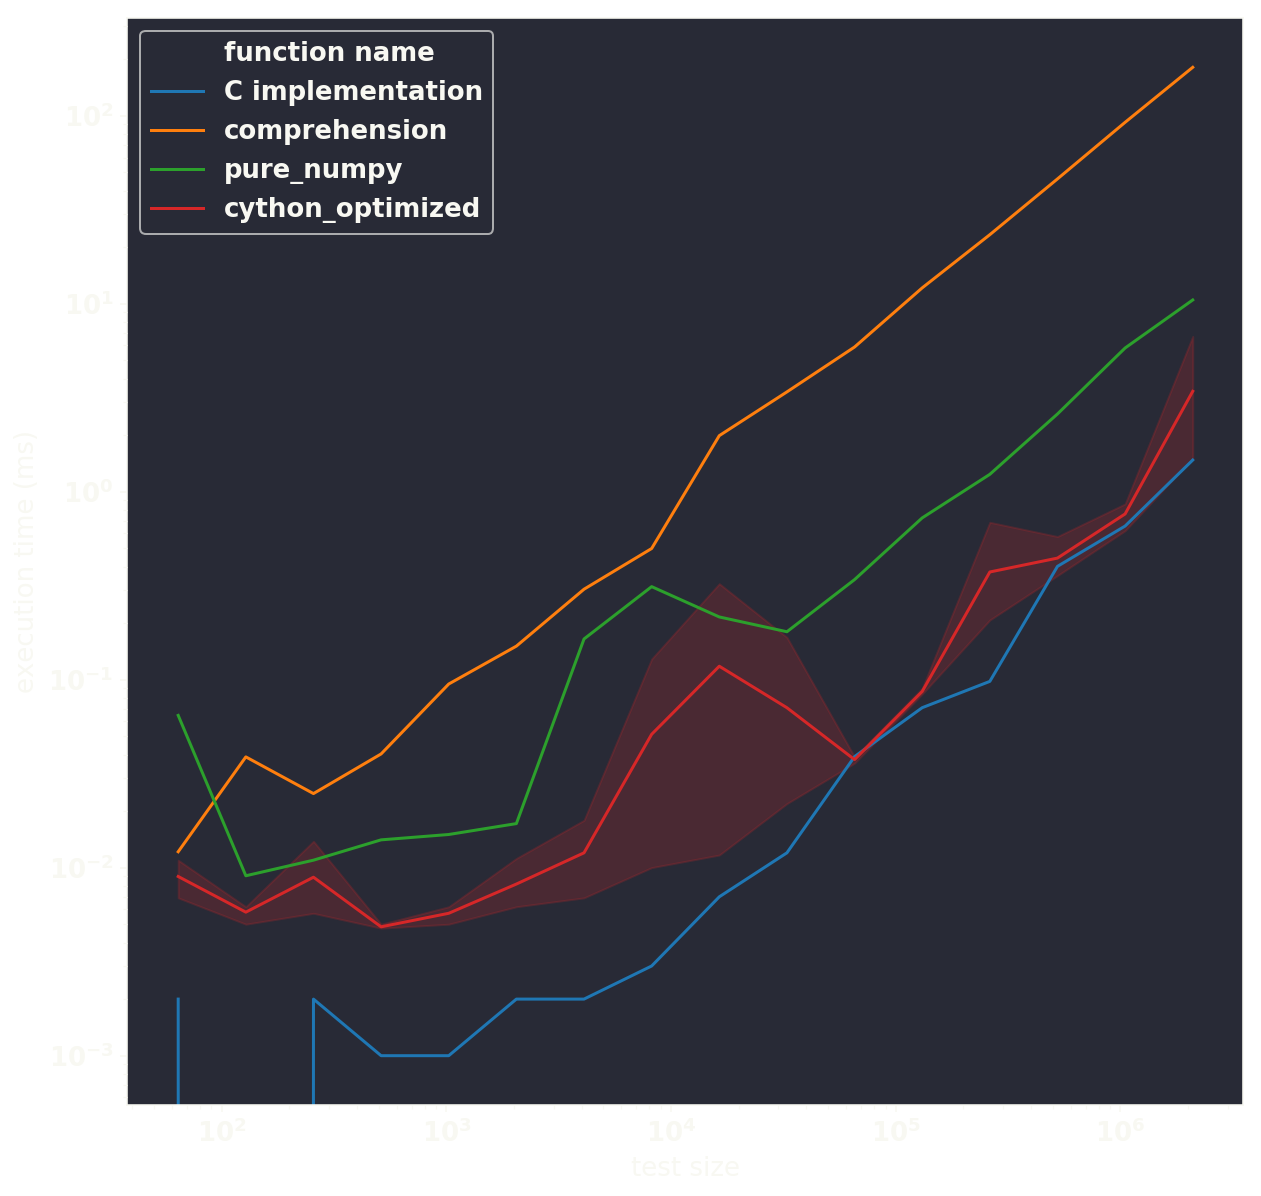

In [26]:
plot_only = {"C implementation", "comprehension", "cython_optimized", "pure_numpy"}
pft.plot_multi_results(results, plot_only=plot_only)

**Observations**

* Numpy was faster than C, Cython is even faster, giving the small differences we can't say much more than C/Cython/Numpy have execution times of the same order of magnitude. 
* The pure cython implementation is more or less equivalent to the numpy with in-place modification of the input array. In both cases we ignore the fact that the array's type and consider it a regular list.

In [17]:
%%cython 

def pure_cython_test(arr):
    print(type(arr))

def typed_cython_test(long[:] arr):
    print(type(arr))

In [18]:
pure_cython_test(np.array([1, 2, 3]))
typed_cython_test(np.array([1, 2, 3]))

<class 'numpy.ndarray'>
<class '_cython_magic_5406aa0df1460c17cb89a838b7cd460c._memoryviewslice'>


Read more about [memory views][memroyview].

[memroyview]: http://docs.cython.org/en/latest/src/userguide/memoryviews.html#view-cython-arrays

If you want to re-use the code I used here to compare perfomances, you can save you some efforts by simply calling the following, for the example I'll also add a [`numba`][numba] implementation so we can test how fast it is!

[numba]: http://numba.pydata.org

Results for the largest test, n=2097152

| Function | Time (ms) | slower by a factor |
|----------|-----------|--------------------|
| C implementation | **1.48** ms | 1.0 |
| numba_numpy_in_place | **1.73** ms | 1.2 |
| cython_optimized | **1.92** ms | 1.3 |
| numba_numpy_in_place_parallel | **2.40** ms | 1.6 |
| pure_numpy | **5.34** ms | 3.6 |
| numba_numpy | **13.20** ms | 8.9 |


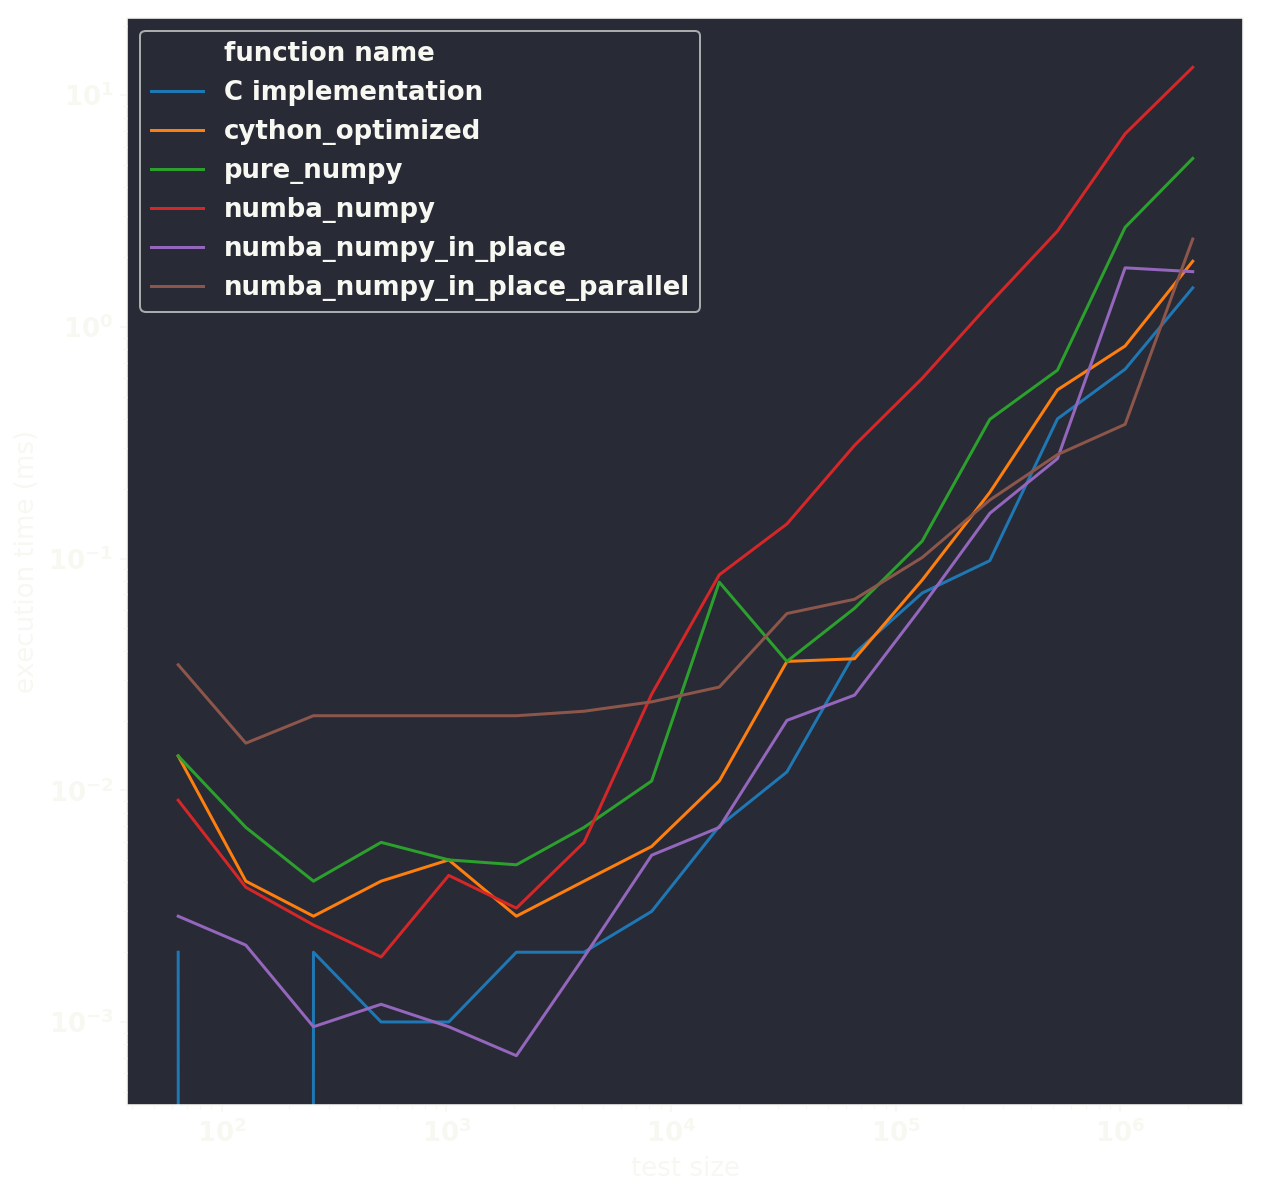

In [20]:
import numba
import perftests as pft

arr = np.array([1, 2, 3])

@pft.init_with(np.array)
@numba.jit(nopython=True)
def numba_numpy(arr):
    return arr + 1

# The first time we call a numba function, it's compiled to machine code, 
# If we want to have real execution time we need to call it once
numba_numpy(arr)

@pft.init_with(np.array)
@numba.jit(nopython=True)
def numba_numpy_in_place(arr):
    for i in range(arr.shape[0]):
        arr[i] += 1 

# Same as before
numba_numpy_in_place(arr)


@pft.init_with(np.array)
@numba.jit(nopython=True, parallel=True, fastmath=True)
def numba_numpy_in_place_parallel(arr):
    for i in numba.prange(arr.shape[0]):
        arr[i] += 1 
        
# And again
numba_numpy_in_place_parallel(arr)

test_cases = [cython_optimized, pure_numpy, 
              numba_numpy, numba_numpy_in_place, numba_numpy_in_place_parallel]
markdown = pft.test_and_plot(MAX_TEST_SIZE, *test_cases, **tests_options)
display(Markdown(markdown))

### Conclusion

Numba seems like the best option so far, we need to try this on more complex examples to see if this holds.

In [25]:
import numba 
import numpy as np

def sum_1(a,b):
    result = 0.0
    for i,j in zip(a,b):
            result += (i+j)
    return result

@numba.jit(nopython=True)
def sum_2(a,b):
    result = 0.0
    for i,j in zip(a,b):
            result += (i+j)
    return result

# try 100
a = np.linspace(1.0,2.0,5)
b = np.linspace(1.0,2.0,5)
print("pure python: ")
%timeit -o sum_1(a,b)
print("python + numba: ")
%timeit -o sum_2(a,b)

pure python: 
3.46 µs ± 100 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
python + numba: 
586 ns ± 15.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
588 ns ± 10.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<TimeitResult : 588 ns ± 10.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>